### Load the Human Data

In [22]:
import os
import glob
import re
import scipy.io
import pandas as pd
import numpy as np

# 폴더 경로
data_dir = '/Users/ijimin/Downloads/Competency-main/Data/S_001'

# 파일 경로 목록
mat_files = glob.glob(os.path.join(data_dir, "trial_*.mat"))

# 숫자 기준 정렬
mat_files = sorted(mat_files, key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))

# 결과 저장 리스트
rows = []

for file_path in mat_files:
    try:
        mat = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
        curr = mat['curr_trial_data']

        # 필수 필드가 전부 있는지 검사
        if not hasattr(curr, "PURSUIT") or not hasattr(curr, "reward_info") or not hasattr(curr, "REPORT") or not hasattr(curr, "eels"):
            print(f"Skipping {file_path}: missing main fields")
            continue

        if not hasattr(curr.PURSUIT, "left_fish_caught") or not hasattr(curr.PURSUIT, "right_fish_caught"):
            print(f"Skipping {file_path}: missing fish_caught fields")
            continue

        if not hasattr(curr.reward_info, "reward_given"):
            print(f"Skipping {file_path}: missing reward_given field")
            continue

        if not hasattr(curr.REPORT, "reported_reliability") or not hasattr(curr.REPORT, "reported_competency") or not hasattr(curr.REPORT, "target_eel_idx"):
            print(f"Skipping {file_path}: missing report fields")
            continue

        if not hasattr(curr.eels[0], "reliability") or not hasattr(curr.eels[1], "reliability"):
            print(f"Skipping {file_path}: missing eel reliability")
            continue

        # 데이터 추출
        if np.array_equal(curr.eels[0].eel_col, [0,0,255]): # 색상기준으로 eel idx 매칭 (eel1: [0, 0, 255], eel2: [157, 0, 255])
            eel1 = curr.eels[0]
            eel2 = curr.eels[1]
        else:
            eel1 = curr.eels[1]
            eel2 = curr.eels[0]
        report = curr.REPORT
        pursuit = curr.PURSUIT

        row = {
            "trial_idx": curr.trial_idx,
            "n1": curr.PURSUIT.left_fish_caught if np.array_equal(eel1.initial_side, 1) else curr.PURSUIT.right_fish_caught,
            "n2": curr.PURSUIT.right_fish_caught if np.array_equal(eel2.initial_side, 2) else curr.PURSUIT.left_fish_caught,
            "reward": bool(curr.reward_info.reward_given),
            "eel1_reliability": eel1.reliability,
            "eel2_reliability": eel2.reliability,
            "eel1_competency": eel1.competency,
            "eel2_competency": eel2.competency,
            "reported_reliability": report.reported_reliability,
            "reported_competency": report.reported_competency,
            "target_eel_idx": 1 if np.array_equal(report.target_eel_color, [0,0,255]) else 2     
        }

        rows.append(row)

    except Exception as e:
        print(f"Failed to load {file_path}: {e}")

# DataFrame으로 변환
df = pd.DataFrame(rows)

# 결과 확인
print(df.iloc[28:32, :])     # 두 번째 행, 모든 열 (빠져있는 trial 반영되었는지 확인)
print(f"총 사용된 trial 수: {len(df)} / {len(mat_files)}")

Skipping /Users/ijimin/Downloads/Competency-main/Data/S_001/trial_30.mat: missing main fields
    trial_idx  n1  n2  reward  eel1_reliability  eel2_reliability  \
28         29   0   0   False               0.1              0.25   
29         31   1   1   False               0.1              0.25   
30         32   0   3   False               0.1              0.25   
31         33   0   0   False               0.1              0.25   

    eel1_competency  eel2_competency  reported_reliability  \
28         0.278316         0.387298                     0   
29         0.278316         0.387298                     0   
30         0.278316         0.387298                     0   
31         0.278316         0.387298                     0   

    reported_competency  target_eel_idx  
28                    0               1  
29                    0               2  
30                    0               1  
31                    0               2  
총 사용된 trial 수: 299 / 300


# Reliability

> ### Hypothesis
* H1: eel1 has higher reliability (0.25)
* H2: eel2 has higher reliability (0.25)

> ### Observation
* Rewarded (1)
* or not (0)

### 1) 실제 reliability?

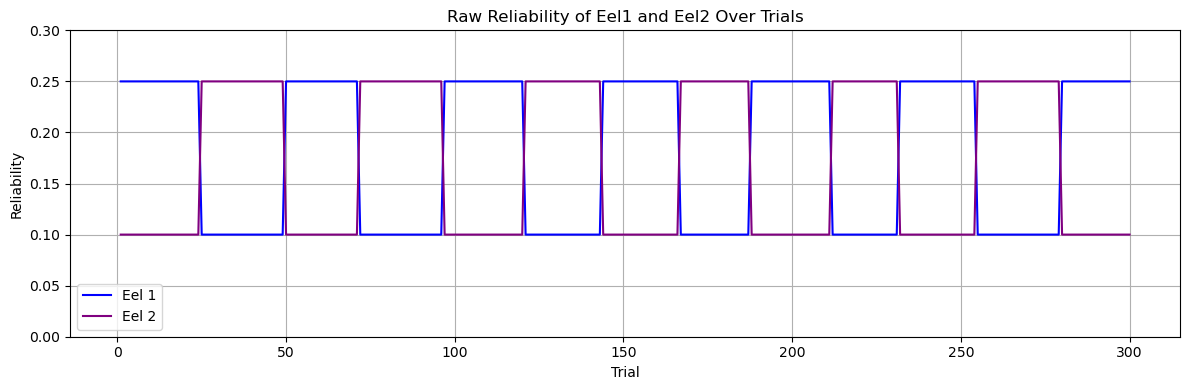

In [23]:
# (1) y축이 0~1로 설정해서 eel1과 eel2의 Raw reliability를 수치로 각각 나타내기

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.plot(df["trial_idx"], df["eel1_reliability"], label="Eel 1", color="blue")
plt.plot(df["trial_idx"], df["eel2_reliability"], label="Eel 2", color="purple")
# plt.plot(df["trial_idx"], df["eel1_reliability"], label="Eel 1", color="skyblue")
# plt.plot(df["trial_idx"], df["eel2_reliability"], label="Eel 2", color="orchid")
plt.xlabel("Trial")
plt.ylabel("Reliability")
plt.title("Raw Reliability of Eel1 and Eel2 Over Trials")
plt.ylim(0, 0.3)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


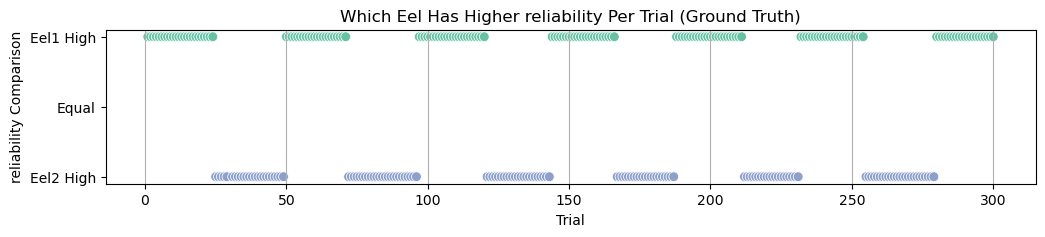

In [24]:
# (3) y축을 high, low로 설정해서 eel1과 eel2를 비교했을 때 뭐가 high, low인지 나타내기 (Categorical)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# eel1과 eel2의 reliability 비교 결과 계산
df["reliability_diff"] = np.sign(df["eel1_reliability"] - df["eel2_reliability"])
df["reliability_label"] = df["reliability_diff"].map({1: "Eel1 High", -1: "Eel2 High", 0: "Equal"})

# y축 순서 지정
order = ["Eel1 High", "Equal", "Eel2 High"]
df["reliability_label"] = pd.Categorical(df["reliability_label"], categories=order, ordered=True)

# 시각화
plt.figure(figsize=(12, 2))
sns.scatterplot(x="trial_idx", y="reliability_label", data=df, hue="reliability_label", palette="Set2", s=50, legend=False)
plt.title("Which Eel Has Higher reliability Per Trial (Ground Truth)")
plt.xlabel("Trial")
plt.ylabel("reliability Comparison")
plt.yticks(order)
plt.grid(True, axis='x')
# plt.tight_layout()
plt.show()



### 2) Reported reliability?

##### Only Reported reliability

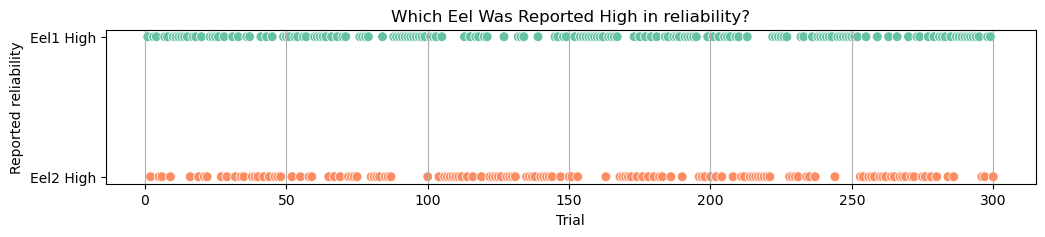

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (가정) df 에는 ['trial_idx','reported_reliability','target_eel_idx'] 컬럼이 있습니다.

# 1) 조건에 맞춰 'Eel1 High' / 'Eel2 High' 레이블 생성
cond = (
    ((df['reported_reliability'] == 1) & (df['target_eel_idx'] == 1)) |
    ((df['reported_reliability'] == 0) & (df['target_eel_idx'] == 2))
)
df['reported_reliability_label'] = np.where(cond, 'Eel1 High', 'Eel2 High')

# 2) 카테고리형으로 순서 고정
order = ['Eel1 High', 'Eel2 High']
df['reported_reliability_label'] = pd.Categorical(
    df['reported_reliability_label'],
    categories=order,
    ordered=True
)

# 3) 시각화
plt.figure(figsize=(12,2))
sns.scatterplot(
    x='trial_idx',
    y='reported_reliability_label',
    data=df,
    hue='reported_reliability_label',
    palette='Set2',
    s=50,
    legend=False
)
plt.yticks(order)
plt.xlabel('Trial')
plt.ylabel('Reported reliability')
plt.title('Which Eel Was Reported High in reliability?')
plt.grid(True, axis='x')
plt.show()


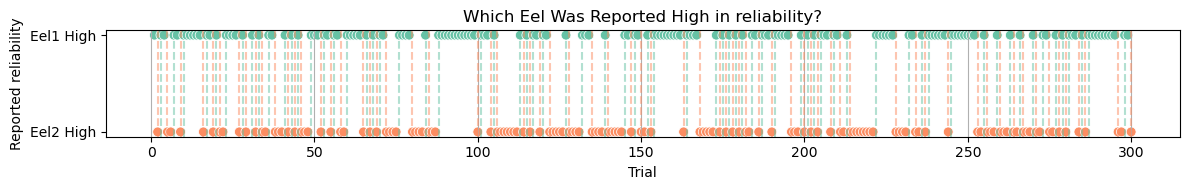

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (가정) df에는 ['trial_idx','reported_reliability','target_eel_idx'] 컬럼이 있습니다.

# 1) 'Eel1 High' / 'Eel2 High' 레이블 생성
cond = (
    ((df['reported_reliability'] == 1) & (df['target_eel_idx'] == 1)) |
    ((df['reported_reliability'] == 0) & (df['target_eel_idx'] == 2))
)
df['reported_reliability_label'] = np.where(cond, 'Eel1 High', 'Eel2 High')

# 2) 카테고리형으로 순서 고정
order = ['Eel1 High', 'Eel2 High']
df['reported_reliability_label'] = pd.Categorical(
    df['reported_reliability_label'],
    categories=order,
    ordered=True
)

# 3) 판단 변화 지점 탐지
label_changes = df['reported_reliability_label'].ne(df['reported_reliability_label'].shift())
change_points = df.loc[label_changes & (df.index > 0), 'trial_idx'].values
change_directions = df.loc[label_changes & (df.index > 0), 'reported_reliability_label'].values

# 4) 시각화
plt.figure(figsize=(12, 2))
ax = sns.scatterplot(
    x='trial_idx',
    y='reported_reliability_label',
    data=df,
    hue='reported_reliability_label',
    palette='Set2',
    s=50,
    legend=False
)

# 5) 세로선 추가: 방향에 따라 색상 지정
for trial, label in zip(change_points, change_directions):
    color = sns.color_palette('Set2')[0] if label == 'Eel1 High' else sns.color_palette('Set2')[1]
    plt.axvline(x=trial, color=color, alpha=0.5, linestyle='--')

# 6) 마무리 설정
plt.yticks(order)
plt.xlabel('Trial')
plt.ylabel('Reported reliability')
plt.title('Which Eel Was Reported High in reliability?')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


##### Ground Truth vs. Reported reliability

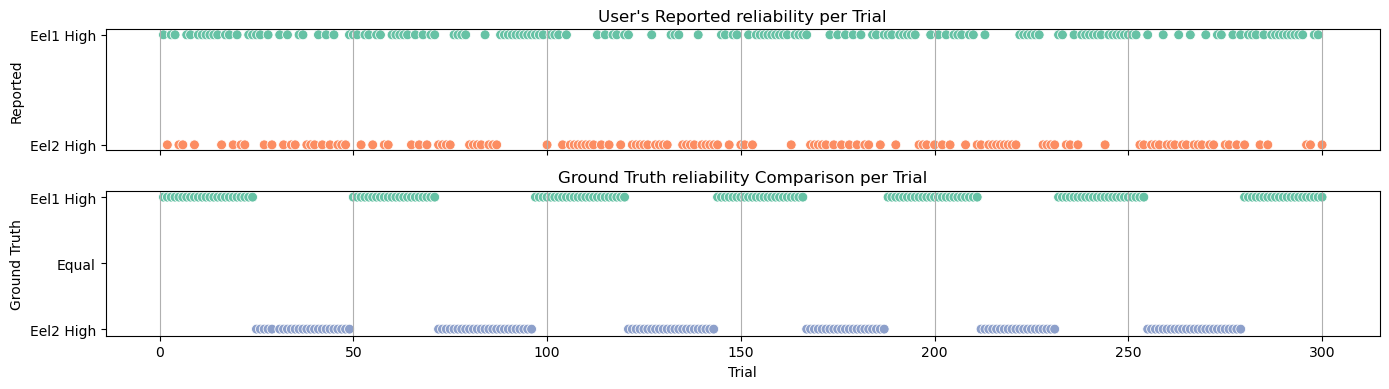

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# reliability ground truth 비교
df["reliability_diff"] = np.sign(df["eel1_reliability"] - df["eel2_reliability"])
df["reliability_label"] = df["reliability_diff"].map({1: "Eel1 High", -1: "Eel2 High", 0: "Equal"})

# y축 순서 지정
cat_order = ["Eel1 High", "Equal", "Eel2 High"]

# Ground truth reliability label
df["reliability_label"] = pd.Categorical(df["reliability_label"], categories=cat_order, ordered=True)

# 사용자 report 기반 판단
cond = (
    ((df['reported_reliability'] == 1) & (df['target_eel_idx'] == 1)) |
    ((df['reported_reliability'] == 0) & (df['target_eel_idx'] == 2))
)
df['reported_reliability_label'] = np.where(cond, 'Eel1 High', 'Eel2 High')
df['reported_reliability_label'] = pd.Categorical(df['reported_reliability_label'], categories=["Eel1 High", "Eel2 High"], ordered=True)

# figure 준비
fig, axes = plt.subplots(2, 1, figsize=(14, 4), sharex=True, height_ratios=[1, 1.2])

# (1) 위쪽: 사용자 주관적 판단
sns.scatterplot(
    ax=axes[0],
    x='trial_idx',
    y='reported_reliability_label',
    data=df,
    hue='reported_reliability_label',
    palette='Set2',
    s=50,
    legend=False
)
axes[0].set_yticks(["Eel1 High", "Eel2 High"])
axes[0].set_ylabel("Reported")
axes[0].set_title("User's Reported reliability per Trial")
axes[0].grid(True, axis='x')

# (2) 아래쪽: ground truth
sns.scatterplot(
    ax=axes[1],
    x='trial_idx',
    y='reliability_label',
    data=df,
    hue='reliability_label',
    palette='Set2',
    s=50,
    legend=False
)
axes[1].set_yticks(cat_order)
axes[1].set_ylabel("Ground Truth")
axes[1].set_xlabel("Trial")
axes[1].set_title("Ground Truth reliability Comparison per Trial")
axes[1].grid(True, axis='x')

plt.tight_layout()
plt.show()


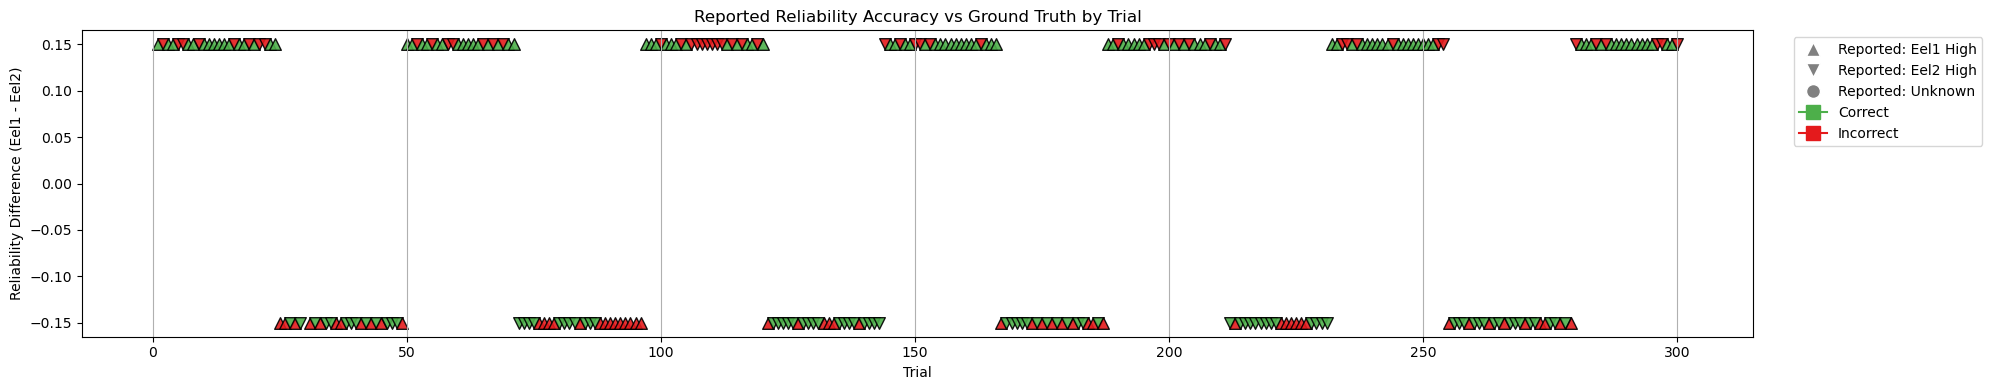

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# reliability 차이 및 정답 여부 계산
df['reliability_diff'] = df['eel1_reliability'] - df['eel2_reliability']
df['abs_diff'] = np.abs(df['reliability_diff'])

# ground truth label
df['gt_label'] = np.select(
    [df['reliability_diff'] > 0, df['reliability_diff'] < 0, df['reliability_diff'] == 0],
    ['Eel1 High', 'Eel2 High', 'Equal'],
    default='Unknown'
)

# 사용자 판단 label
df['reported_label'] = np.select(
    [((df['reported_reliability'] == 1) & (df['target_eel_idx'] == 1)) | ((df['reported_reliability'] == 0) & (df['target_eel_idx'] == 2)),
     ((df['reported_reliability'] == 1) & (df['target_eel_idx'] == 2)) | ((df['reported_reliability'] == 0) & (df['target_eel_idx'] == 1))],
    ['Eel1 High', 'Eel2 High'],
    default='Unknown'
)

# 정답 여부
df['correct'] = (df['reported_label'] == df['gt_label'])

# 마커 모양 지정
df['marker'] = df['reported_label'].map({
    'Eel1 High': '^',
    'Eel2 High': 'v',
    'Unknown': 'o'
})

# 색상 지정
palette = sns.color_palette("Set1", 3)
color_map = {True: palette[2], False: palette[0]}
df['color'] = df['correct'].map(color_map)

# df['color'] = df['correct'].map({True: 'green', False: 'red'})

# 시각화
plt.figure(figsize=(20, 4))
for i, row in df.iterrows():
    plt.scatter(
        # row['trial_idx'], row['abs_diff'],
        row['trial_idx'], row['reliability_diff'],
        color=row['color'],
        marker=row['marker'],
        s=70,
        alpha=0.9,
        edgecolors='k'
    )

# 범례 수동 작성
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Reported: Eel1 High', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='v', color='w', label='Reported: Eel2 High', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Reported: Unknown', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='s', color=color_map[True], label='Correct', markersize=10),
    Line2D([0], [0], marker='s', color=color_map[False], label='Incorrect', markersize=10)
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.xlabel("Trial")
# plt.ylabel("reliability Difference (|Eel1 - Eel2|)")
plt.ylabel("Reliability Difference (Eel1 - Eel2)")
plt.title("Reported Reliability Accuracy vs Ground Truth by Trial")
plt.grid(True, axis='x')
plt.tight_layout()


plt.show()


In [29]:
print(f"correct: {sum(df['correct']==1)}")
print(f"correct: {sum(df['correct']==0)}")

correct: 189
correct: 110


In [30]:
# Unknown이 발생한 trial 살펴보기 -> 없어야 맞음
unknown_df = df[df['reported_label'] == 'Unknown'][['trial_idx', 'reported_reliability', 'target_eel_idx', 'gt_label', 'reported_label']]

if len(unknown_df) == 0:
    print("No unknown")
else: 
    print(unknown_df)

No unknown


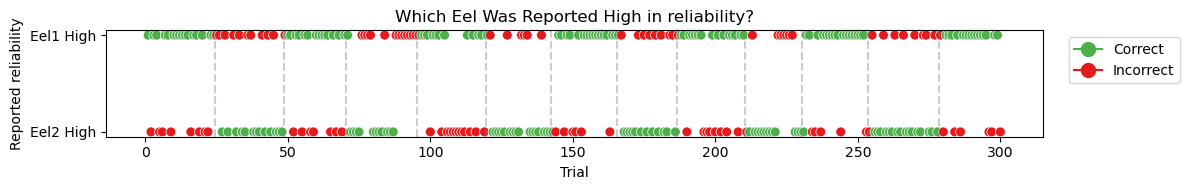

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# 색상 팔레트 (정답: 초록, 오답: 주황)
palette = sns.color_palette("Set1", 4)
color_map = {True: palette[2], False: palette[0]}
df['color'] = df['correct'].map(color_map)

# 시각화
plt.figure(figsize=(12, 2))
sns.scatterplot(
    x='trial_idx',
    y='reported_reliability_label',  # y축에 Eel1 High / Eel2 High 유지
    data=df,
    hue='correct',                  # 색상 기준은 correct
    palette=color_map,
    s=50,
    legend=False,
    # edgecolor='black',             # 외곽선
    linewidth=0.5
)

# 레전드
legend_elements = [
    Line2D([0], [0], marker='o', color=color_map[True], label='Correct', markersize=10),
    Line2D([0], [0], marker='o', color=color_map[False], label='Incorrect', markersize=10)
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')

# 라벨 및 꾸미기
plt.xlabel('Trial')
plt.ylabel('Reported reliability')
plt.title('Which Eel Was Reported High in reliability?')
# plt.grid(True, axis='x')

# 보조 선 추가 (예: 확실성 기준선)
trials_reliability_changed = []

trials_reliability_changed = [
    i for i in range(len(df) - 1)
    if df.iloc[i]["eel1_reliability"] != df.iloc[i + 1]["eel1_reliability"]
]

for t in trials_reliability_changed:
    plt.axvline(x=t+1.5, color='gray', linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()


##### (A) 누적 정답률 Plot (누적 정답 / 진행 trial 수)

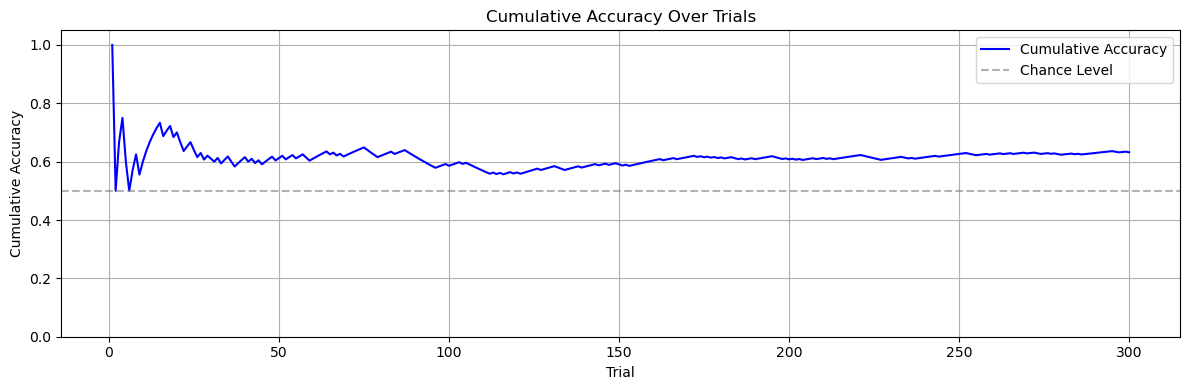

In [32]:
df['cumulative_correct'] = df['correct'].cumsum()
df['cumulative_accuracy'] = df['cumulative_correct'] / (df.index + 1)

plt.figure(figsize=(12,4))
plt.plot(df['trial_idx'], df['cumulative_accuracy'], label='Cumulative Accuracy', color='blue')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.6, label='Chance Level')
plt.xlabel("Trial")
plt.ylabel("Cumulative Accuracy")
plt.title("Cumulative Accuracy Over Trials")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


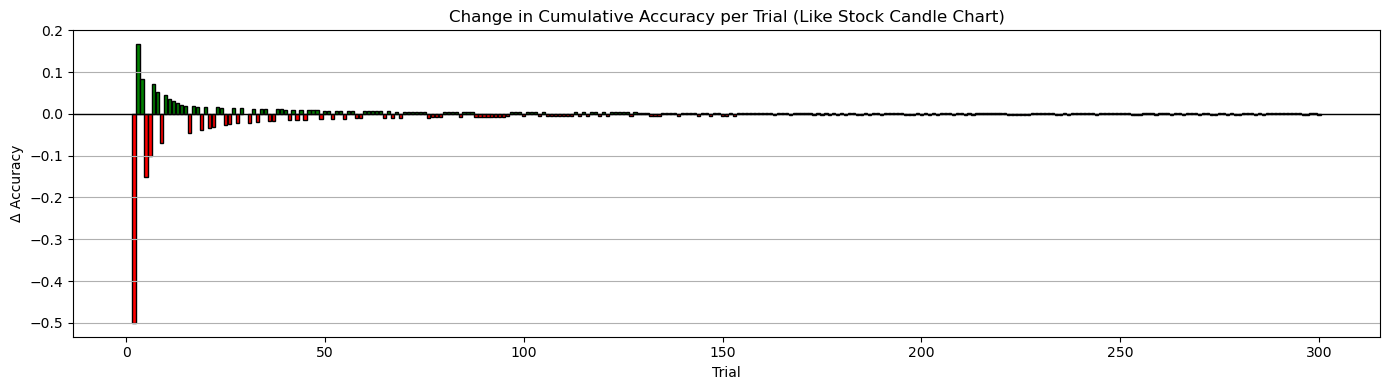

In [33]:
# 누적 정확도 계산
df['cumulative_correct'] = df['correct'].cumsum()
df['cumulative_accuracy'] = df['cumulative_correct'] / (df.index + 1)
df['cumulative_accuracy_shifted'] = df['cumulative_accuracy'].shift(1)
df['delta_accuracy'] = df['cumulative_accuracy'] - df['cumulative_accuracy_shifted']

# 증감 색상: 증가면 초록, 감소면 빨강
df['delta_color'] = df['delta_accuracy'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'gray'))

# 막대그래프 그리기
plt.figure(figsize=(14, 4))
plt.bar(df['trial_idx'], df['delta_accuracy'], color=df['delta_color'], edgecolor='black', width=0.8)
plt.axhline(0, color='black', linewidth=1)
plt.title("Change in Cumulative Accuracy per Trial (Like Stock Candle Chart)")
plt.xlabel("Trial")
plt.ylabel("Δ Accuracy")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


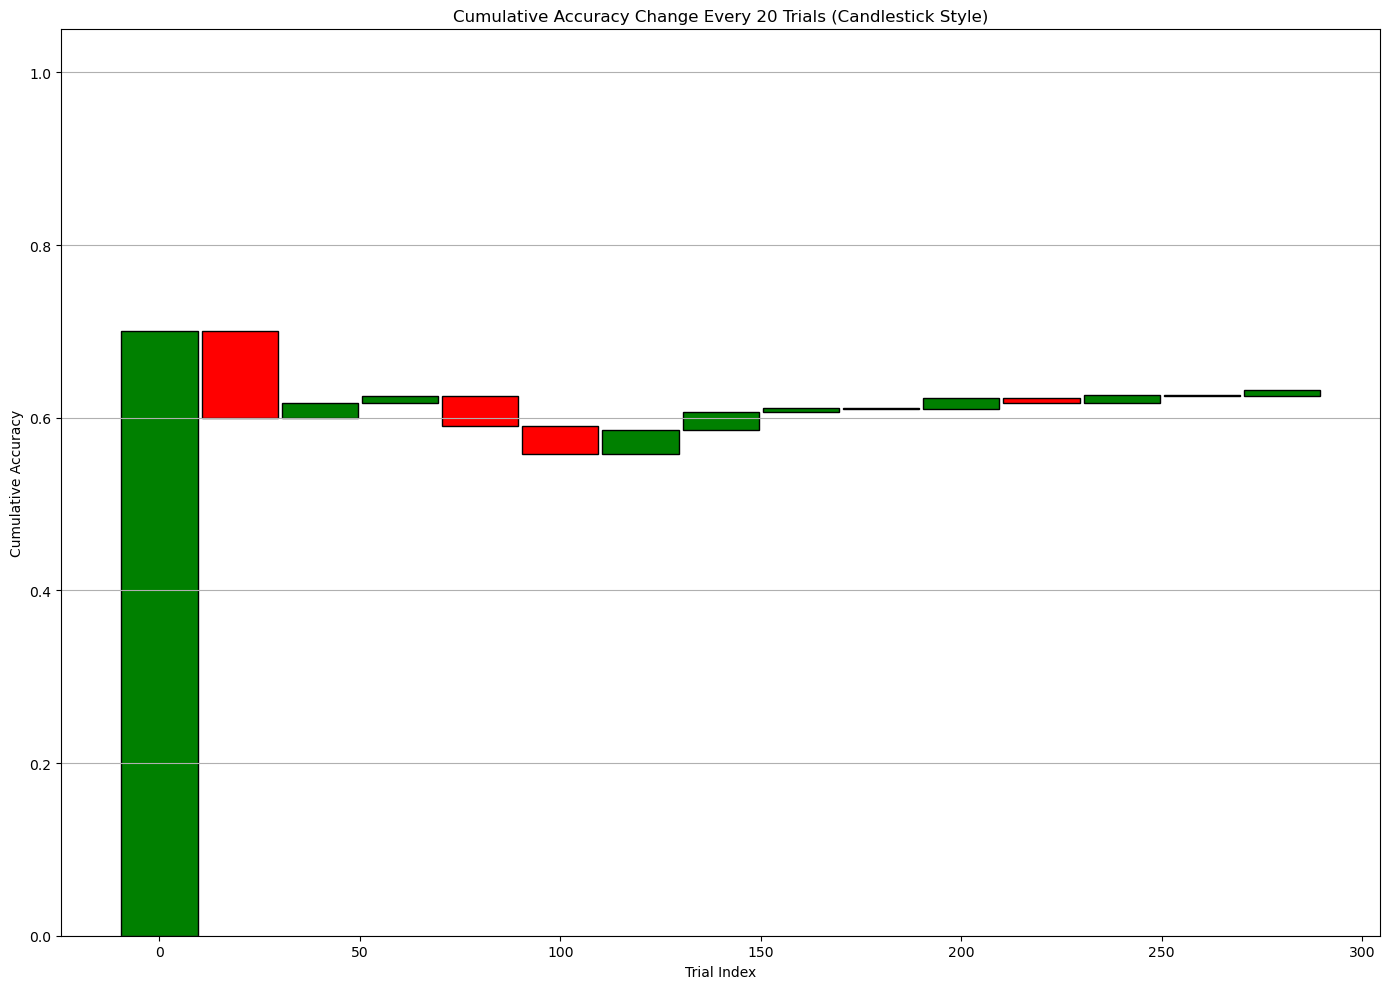

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# 누적 정답 수 및 정확도 계산
df['cumulative_correct'] = df['correct'].cumsum()
df['cumulative_accuracy'] = df['cumulative_correct'] / (df.index + 1)

# 몇 개씩 묶을 것인지 설정
step = 20
n = len(df)
segment_start_idxs = list(range(0, n, step))

bars = []

for i, start in enumerate(segment_start_idxs):
    end = min(start + step, n)
    # 해당 구간의 마지막 누적 정확도
    acc_end = df.loc[end - 1, 'cumulative_accuracy']
    
    # 시작 누적 정확도 (구간 시작 전 trial의 누적값)
    if start == 0:
        acc_start = 0
    else:
        acc_start = df.loc[start - 1, 'cumulative_accuracy']
    
    change = acc_end - acc_start
    color = 'green' if change >= 0 else 'red'
    
    bars.append({
        'x': start,
        'width': step,
        'acc_start': acc_start,
        'acc_end': acc_end,
        'height': acc_end - acc_start,
        'color': color
        })

# 시각화
plt.figure(figsize=(14, 10))

for bar in bars:
    plt.bar(
        bar['x'], bar['height'],
        width=bar['width'] * 0.95,
        bottom=bar['acc_start'],
        color=bar['color'],
        align='center',
        edgecolor='black'
    )

plt.xlabel("Trial Index")
plt.ylabel("Cumulative Accuracy")
plt.title(f"Cumulative Accuracy Change Every {step} Trials (Candlestick Style)")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


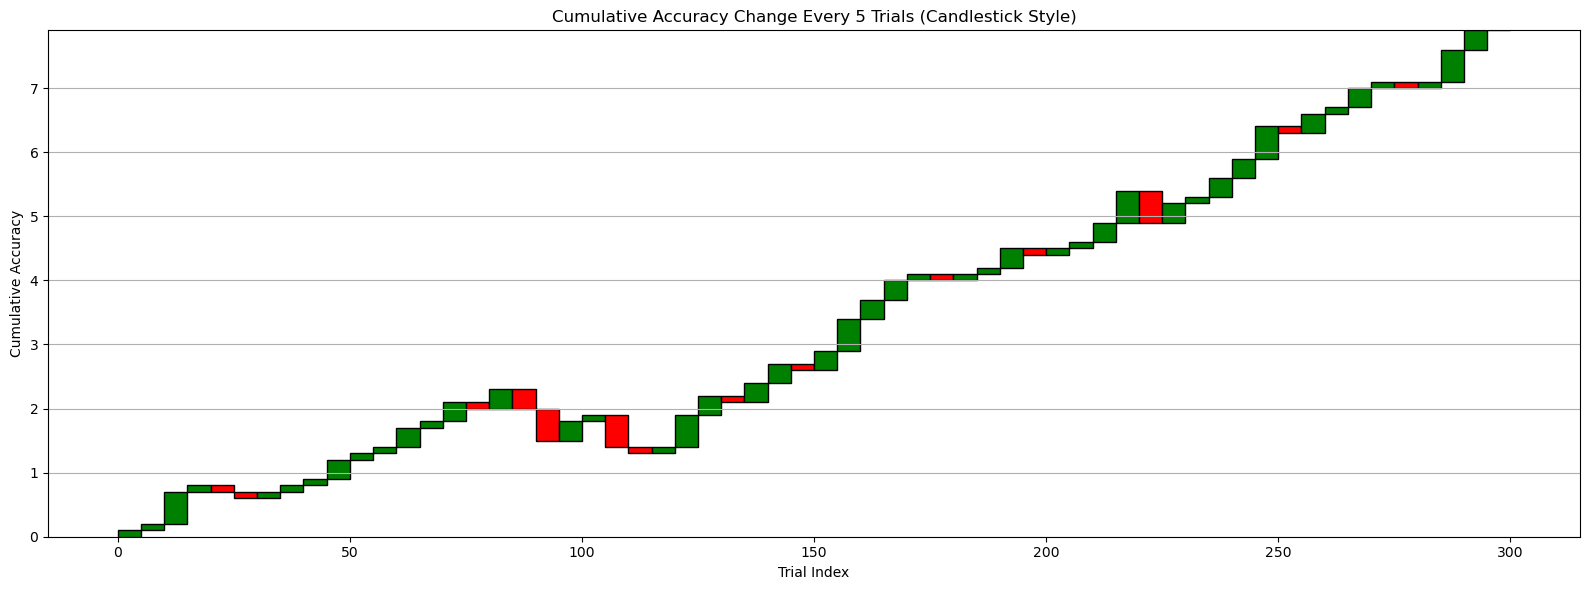

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# 누적 정확도 및 step size
step_size = 5
bars = []

# 초기 값
start_acc = 0.0
start_x = 0

# 누적 정확도 기반 막대 계산
for i in range(0, len(df), step_size):
    end_x = start_x + step_size
    corrects = df.iloc[i:i+step_size]['correct']
    
    if len(corrects) == 0:
        continue
    
    step_acc = corrects.mean()
    end_acc = start_acc + (step_acc - 0.5)  # 예: 평균이 0.6이면 0.1 상승
    height = end_acc - start_acc
    
    color = 'green' if height >= 0 else 'red'
    
    bars.append({
        'x': start_x,
        'width': step_size,
        'acc_start': start_acc,
        'height': height,
        'color': color
    })
    
    # 다음 시작점 갱신
    start_acc = end_acc
    start_x = end_x  # 다음 막대 시작점은 현재 끝점

# 시각화
plt.figure(figsize=(16, 6))
for bar in bars:
    plt.bar(
        bar['x'], bar['height'],
        width=bar['width'],
        bottom=bar['acc_start'],
        color=bar['color'],
        edgecolor='black',
        align='edge'  # 'edge'를 그대로 사용하되 간격을 정확히 붙임
    )

plt.xlabel("Trial Index")
plt.ylabel("Cumulative Accuracy")
plt.title("Cumulative Accuracy Change Every 5 Trials (Candlestick Style)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


##### (B) 정확/오답 개수 누적 막대 그래프

correct
True     189
False    110
Name: count, dtype: int64


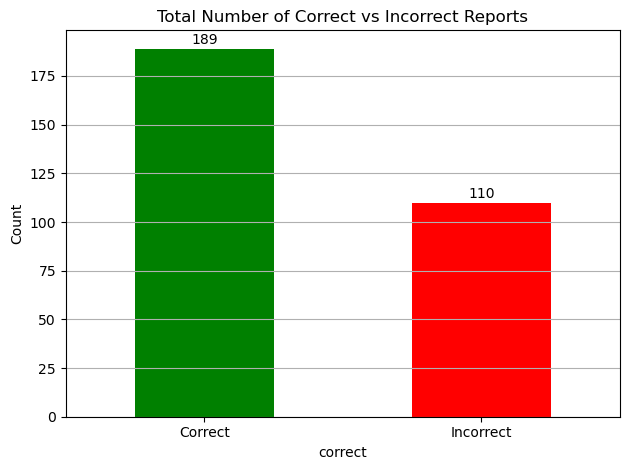

In [36]:
correct_count = df['correct'].value_counts()

print(correct_count)

# 그래프 그리기
correct_count.plot(kind='bar', color=['green', 'red'], rot=0)

# 래이블
plt.xticks([0, 1], ['Correct', 'Incorrect'])
plt.title("Total Number of Correct vs Incorrect Reports")
plt.ylabel("Count")

# 바 위에 값 표시
for i, count in enumerate(correct_count):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

# 격자와 레이아웃
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### (C) reliability 차이(|diff|)에 따른 정답 확률 히트맵/라인 그래프

### 3) Bayesian reliability

> 질문: 각 eel의 실제 reliability가 15–18번 Trial 주기로 바뀔 때, 사용자가 그 변화를 학습하여 ‘지금 더 잘 잡히는(eel의 θ가 높은) eel’ 쪽에서 물고기를 더 많이 잡도록 선택·행동했는가?

각 사후평균(mean1, mean2)은 “해당 시점까지 관찰된 물고기 잡은 개수에 근거해, 각 eel의 진짜 성공확률 θ를 가장 그럴듯하게 추정한 값”
* mean1 > mean2 = **eel1의 reliability θ₁**을 eel2의 θ₂보다 높게 평가하고 있다
* mean1 < mean2 = eel1의 reliability θ₁보다 **eel2의 θ₂**를 높게 평가하고 있다

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 10 tune and 50_000 draw iterations (40 + 200_000 draws total) took 200 seconds.
/opt/anaconda3/envs/eeltask/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (598) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'theta1\n0'}>,
        <Axes: title={'center': 'theta1\n1'}>,
        <Axes: title={'center': 'theta1\n2'}>,
        <Axes: title={'center': 'theta1\n3'}>],
       [<Axes: title={'center': 'theta1\n4'}>,
        <Axes: title={'center': 'theta1\n5'}>,
        <Axes: title={'center': 'theta1\n6'}>,
        <Axes: title={'center': 'theta1\n7'}>],
       [<Axes: title={'center': 'theta1\n8'}>,
        <Axes: title={'center': 'theta1\n9'}>,
        <Axes: title={'center': 'theta1\n10'}>,
        <Axes: title={'center': 'theta1\n11'}>],
       [<Axes: title={'center': 'theta1\n12'}>,
        <Axes: title={'center': 'theta1\n13'}>,
        <Axes: title={'center': 'theta1\n14'}>,
        <Axes: title={'center': 'theta1\n15'}>],
       [<Axes: title={'center': 'theta1\n16'}>,
        <Axes: title={'center': 'theta1\n17'}>,
        <Axes: title={'center': 'theta1\n18'}>,
        <Axes: title={'center': 'theta1\n19'}>],
       [<Axes: title={'center': 'theta1\n20'}

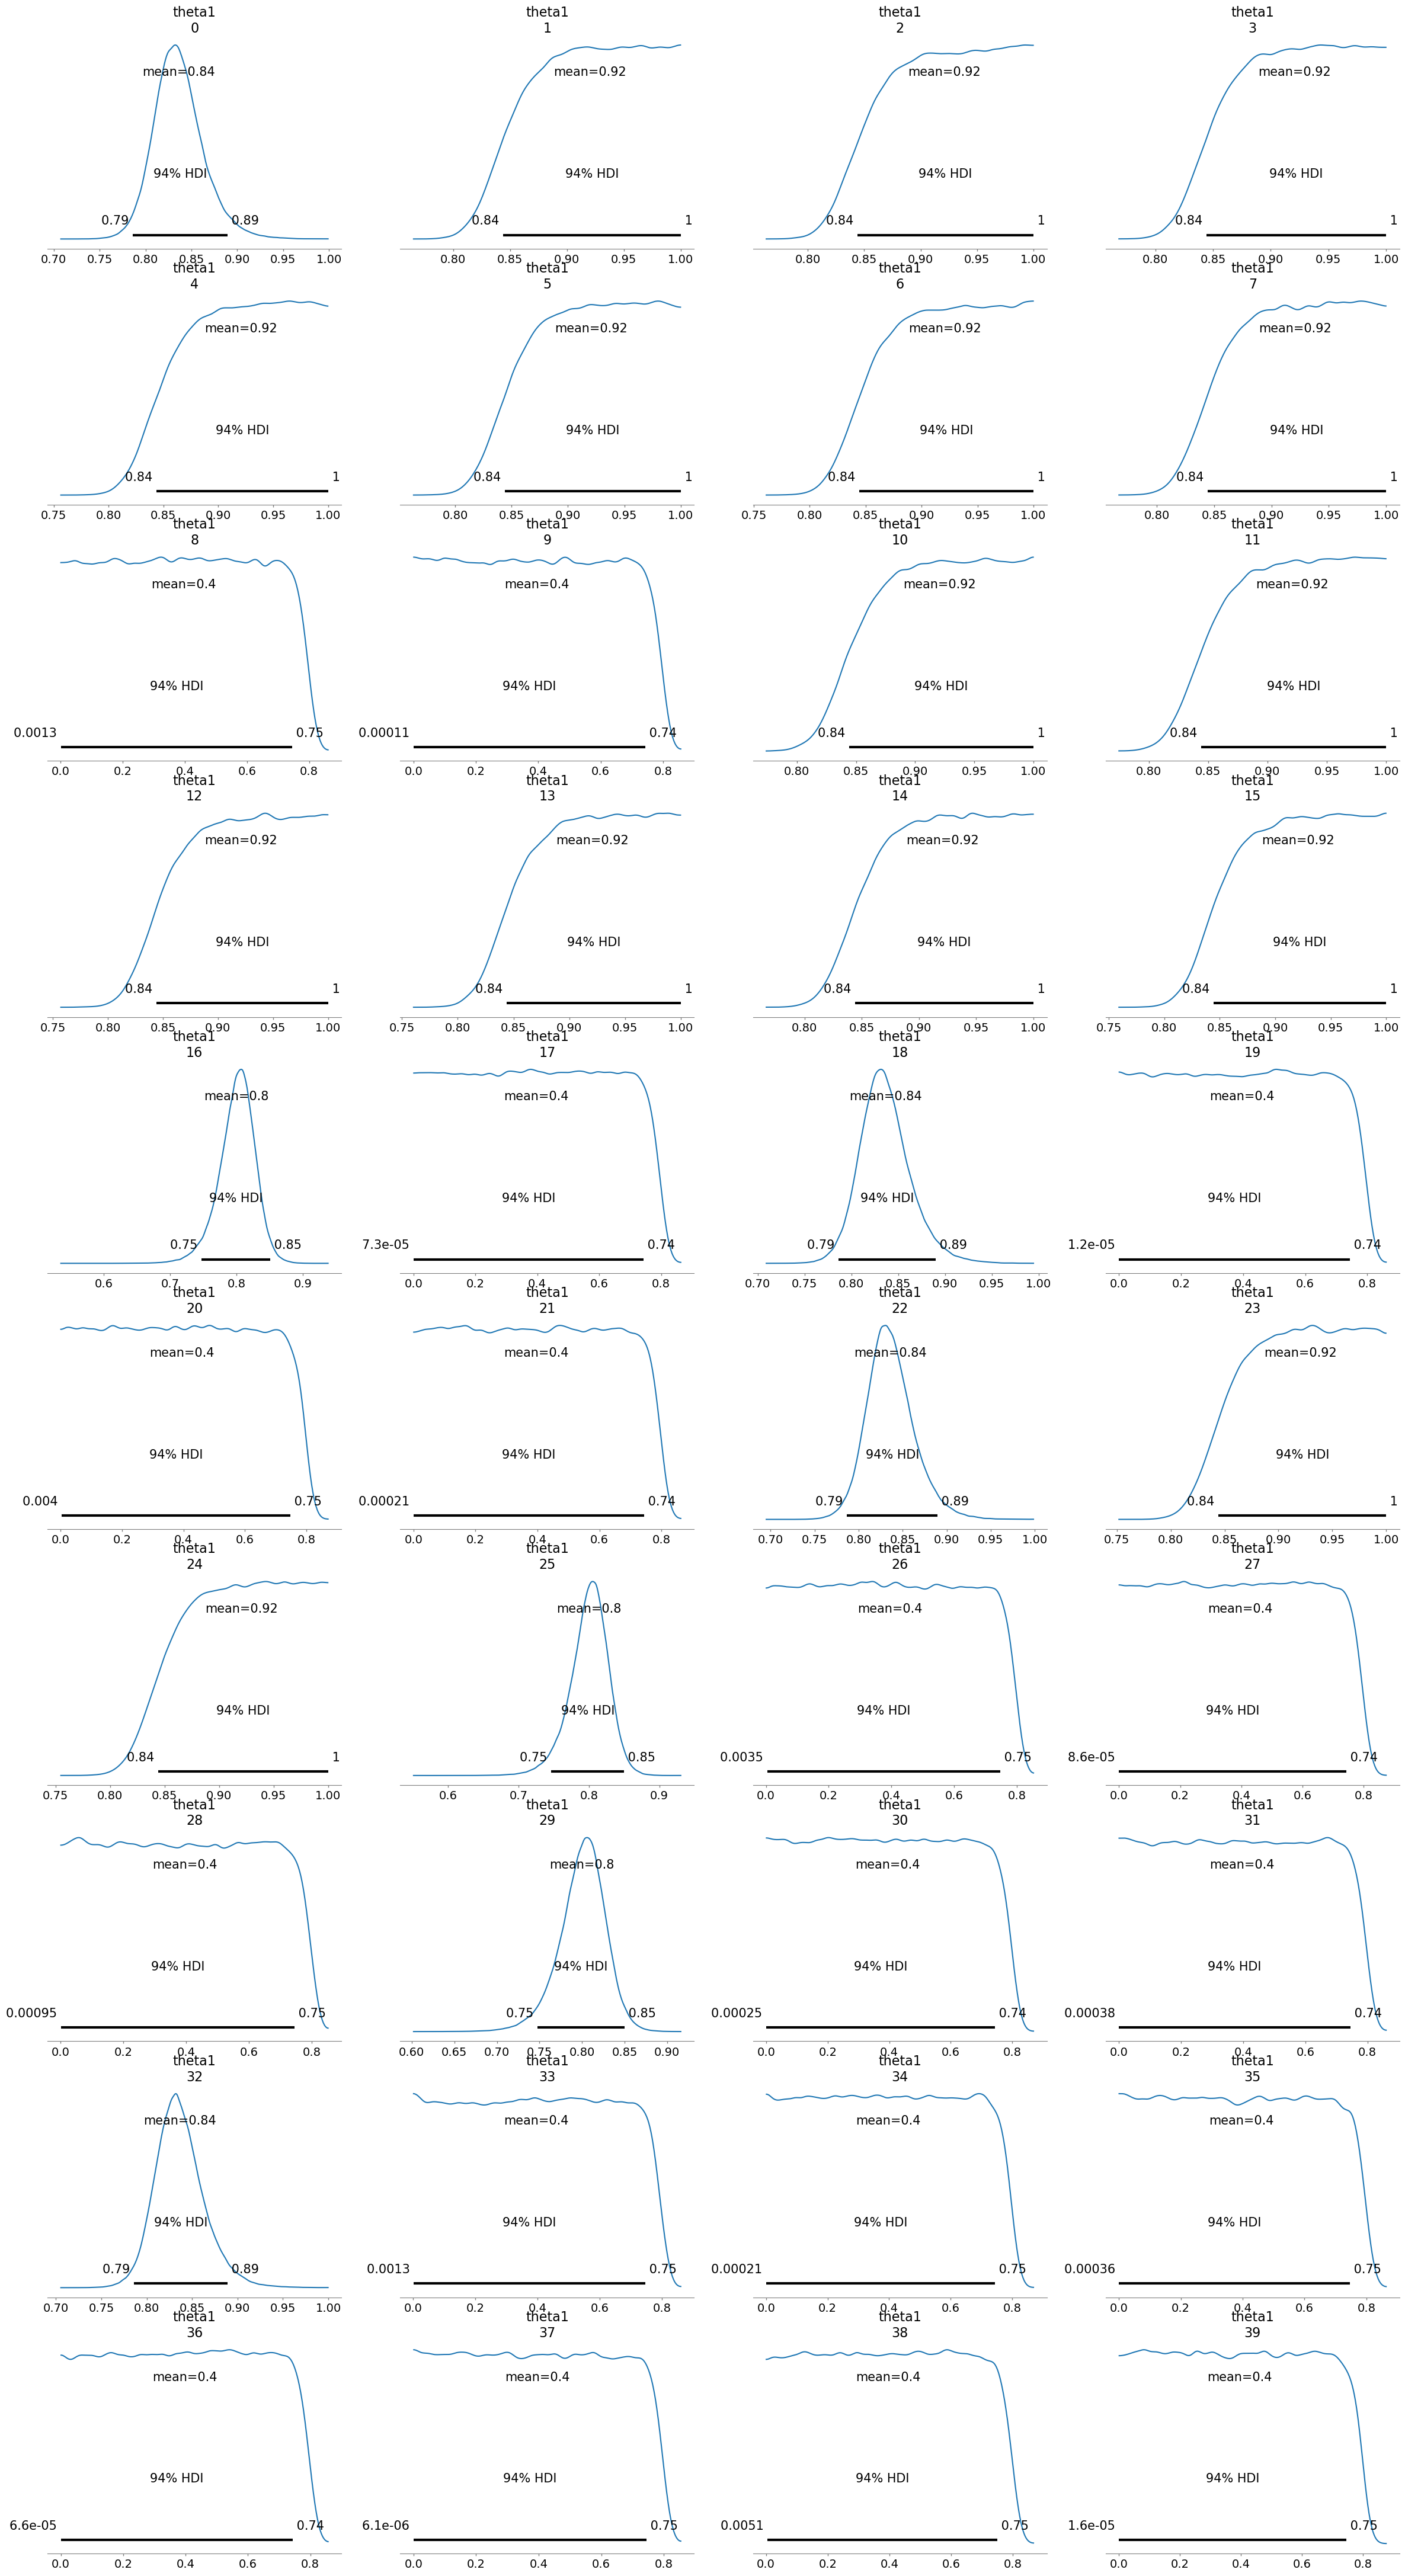

In [38]:
import pymc as pm
import numpy as np
import pandas as pd

N = 3

with pm.Model() as model:
    # Prior: eel reliability
    # theta1 = pm.Beta('theta1', alpha=1, beta=1)
    # theta2 = pm.Beta('theta2', alpha=1, beta=1)
    theta1 = pm.Beta('theta1', alpha=1, beta=1, shape=len(df))
    theta2 = pm.Beta('theta2', alpha=1, beta=1, shape=len(df))


    # Deterministic: fish movement speed
    # mu1 = pm.Deterministic('mu1', pm.math.exp(-2 * theta1))
    # mu2 = pm.Deterministic('mu2', pm.math.exp(-2 * theta2))
    mu1 = pm.Deterministic('mu1', 11 * (1-theta1))  # 기존 코드에 speed = fast_spd(=11) * (1-reliability)
    mu2 = pm.Deterministic('mu2', 11 * (1-theta2))

    # Movement → catch probability
    def p(mu):
        return 1 / (1 + pm.math.exp(-5 * (2 - mu)))  # example function

    p1 = p(mu1)
    p2 = p(mu2)

    # Observed data (잡은 물고기 수)
    n1_obs = df['n1'].values
    n2_obs = df['n2'].values

    # Likelihood: 잡은 물고기 수 (Binomial)
    y1 = pm.Binomial('y1', n=N, p=p1, observed=n1_obs)
    y2 = pm.Binomial('y2', n=N, p=p2, observed=n2_obs)

    trace = pm.sample(50000, tune=10, return_inferencedata=True)

import arviz as az
az.plot_posterior(trace, var_names=['theta1', 'theta2'])


In [39]:
import pandas as pd
import numpy as np

# df: DataFrame with columns ['trial_idx', 'n1', 'n2', ...]
# Parameters
N = 3                    # 각 eel별 최대 물고기 수 (또는 시도 횟수)
W = 10                   # 슬라이딩 윈도우 크기 (최근 15 trials만 고려)
n_samps = 10000          # Monte Carlo 샘플 수 (Beta 분포 샘플링용)

# 결과 저장
records = []

for i in range(len(df)):
    # 슬라이딩 윈도우 범위 설정
    start = max(0, i - W + 1)   # 범위: start(=i-15) ~ i
    window = df.iloc[start:i+1]
    t = len(window)
    
    # 윈도우 내 성공/실패 합계
    s1 = window['n1'].sum()
    f1 = (window['n1']==0).count() * N - s1
    s2 = window['n2'].sum()
    f2 = (window['n2']==0).count() * N - s2

    # Beta posterior 파라미터
    alpha1, beta1 = 1 + s1, 1 + f1
    alpha2, beta2 = 1 + s2, 1 + f2

    # Posterior mean
    mean1 = alpha1 / (alpha1 + beta1)
    mean2 = alpha2 / (alpha2 + beta2)

    # Monte Carlo로 P(theta1 > theta2)
    x = np.random.beta(alpha1, beta1, size=n_samps)
    y = np.random.beta(alpha2, beta2, size=n_samps)
    p12 = np.mean(x > y)

    records.append({
        'trial': df.at[i, 'trial_idx'],
        'alpha1': alpha1, 'beta1': beta1,
        'alpha2': alpha2, 'beta2': beta2,
        'mean1': mean1, 'mean2': mean2,
        'P(theta1>theta2)': p12
    })

# DataFrame으로 변환
post_df = pd.DataFrame(records)
print(post_df.head(30))


    trial  alpha1  beta1  alpha2  beta2     mean1     mean2  P(theta1>theta2)
0       1       3      2       1      4  0.600000  0.200000            0.9281
1       2       6      2       1      7  0.750000  0.125000            0.9979
2       3       9      2       1     10  0.818182  0.090909            0.9999
3       4      12      2       1     13  0.857143  0.071429            1.0000
4       5      15      2       1     16  0.882353  0.058824            1.0000
5       6      18      2       1     19  0.900000  0.050000            1.0000
6       7      21      2       1     22  0.913043  0.043478            1.0000
7       8      24      2       1     25  0.923077  0.038462            1.0000
8       9      24      5       1     28  0.827586  0.034483            1.0000
9      10      24      8       2     30  0.750000  0.062500            1.0000
10     11      25      7       2     30  0.781250  0.062500            1.0000
11     12      25      7       2     30  0.781250  0.062500     

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'theta1\n0'}>,
        <Axes: title={'center': 'theta1\n1'}>,
        <Axes: title={'center': 'theta1\n2'}>,
        <Axes: title={'center': 'theta1\n3'}>],
       [<Axes: title={'center': 'theta1\n4'}>,
        <Axes: title={'center': 'theta1\n5'}>,
        <Axes: title={'center': 'theta1\n6'}>,
        <Axes: title={'center': 'theta1\n7'}>],
       [<Axes: title={'center': 'theta1\n8'}>,
        <Axes: title={'center': 'theta1\n9'}>,
        <Axes: title={'center': 'theta1\n10'}>,
        <Axes: title={'center': 'theta1\n11'}>],
       [<Axes: title={'center': 'theta1\n12'}>,
        <Axes: title={'center': 'theta2\n0'}>,
        <Axes: title={'center': 'theta2\n1'}>,
        <Axes: title={'center': 'theta2\n2'}>],
       [<Axes: title={'center': 'theta2\n3'}>,
        <Axes: title={'center': 'theta2\n4'}>,
        <Axes: title={'center': 'theta2\n5'}>,
        <Axes: title={'center': 'theta2\n6'}>],
       [<Axes: title={'center': 'theta2\n7'}>,
     

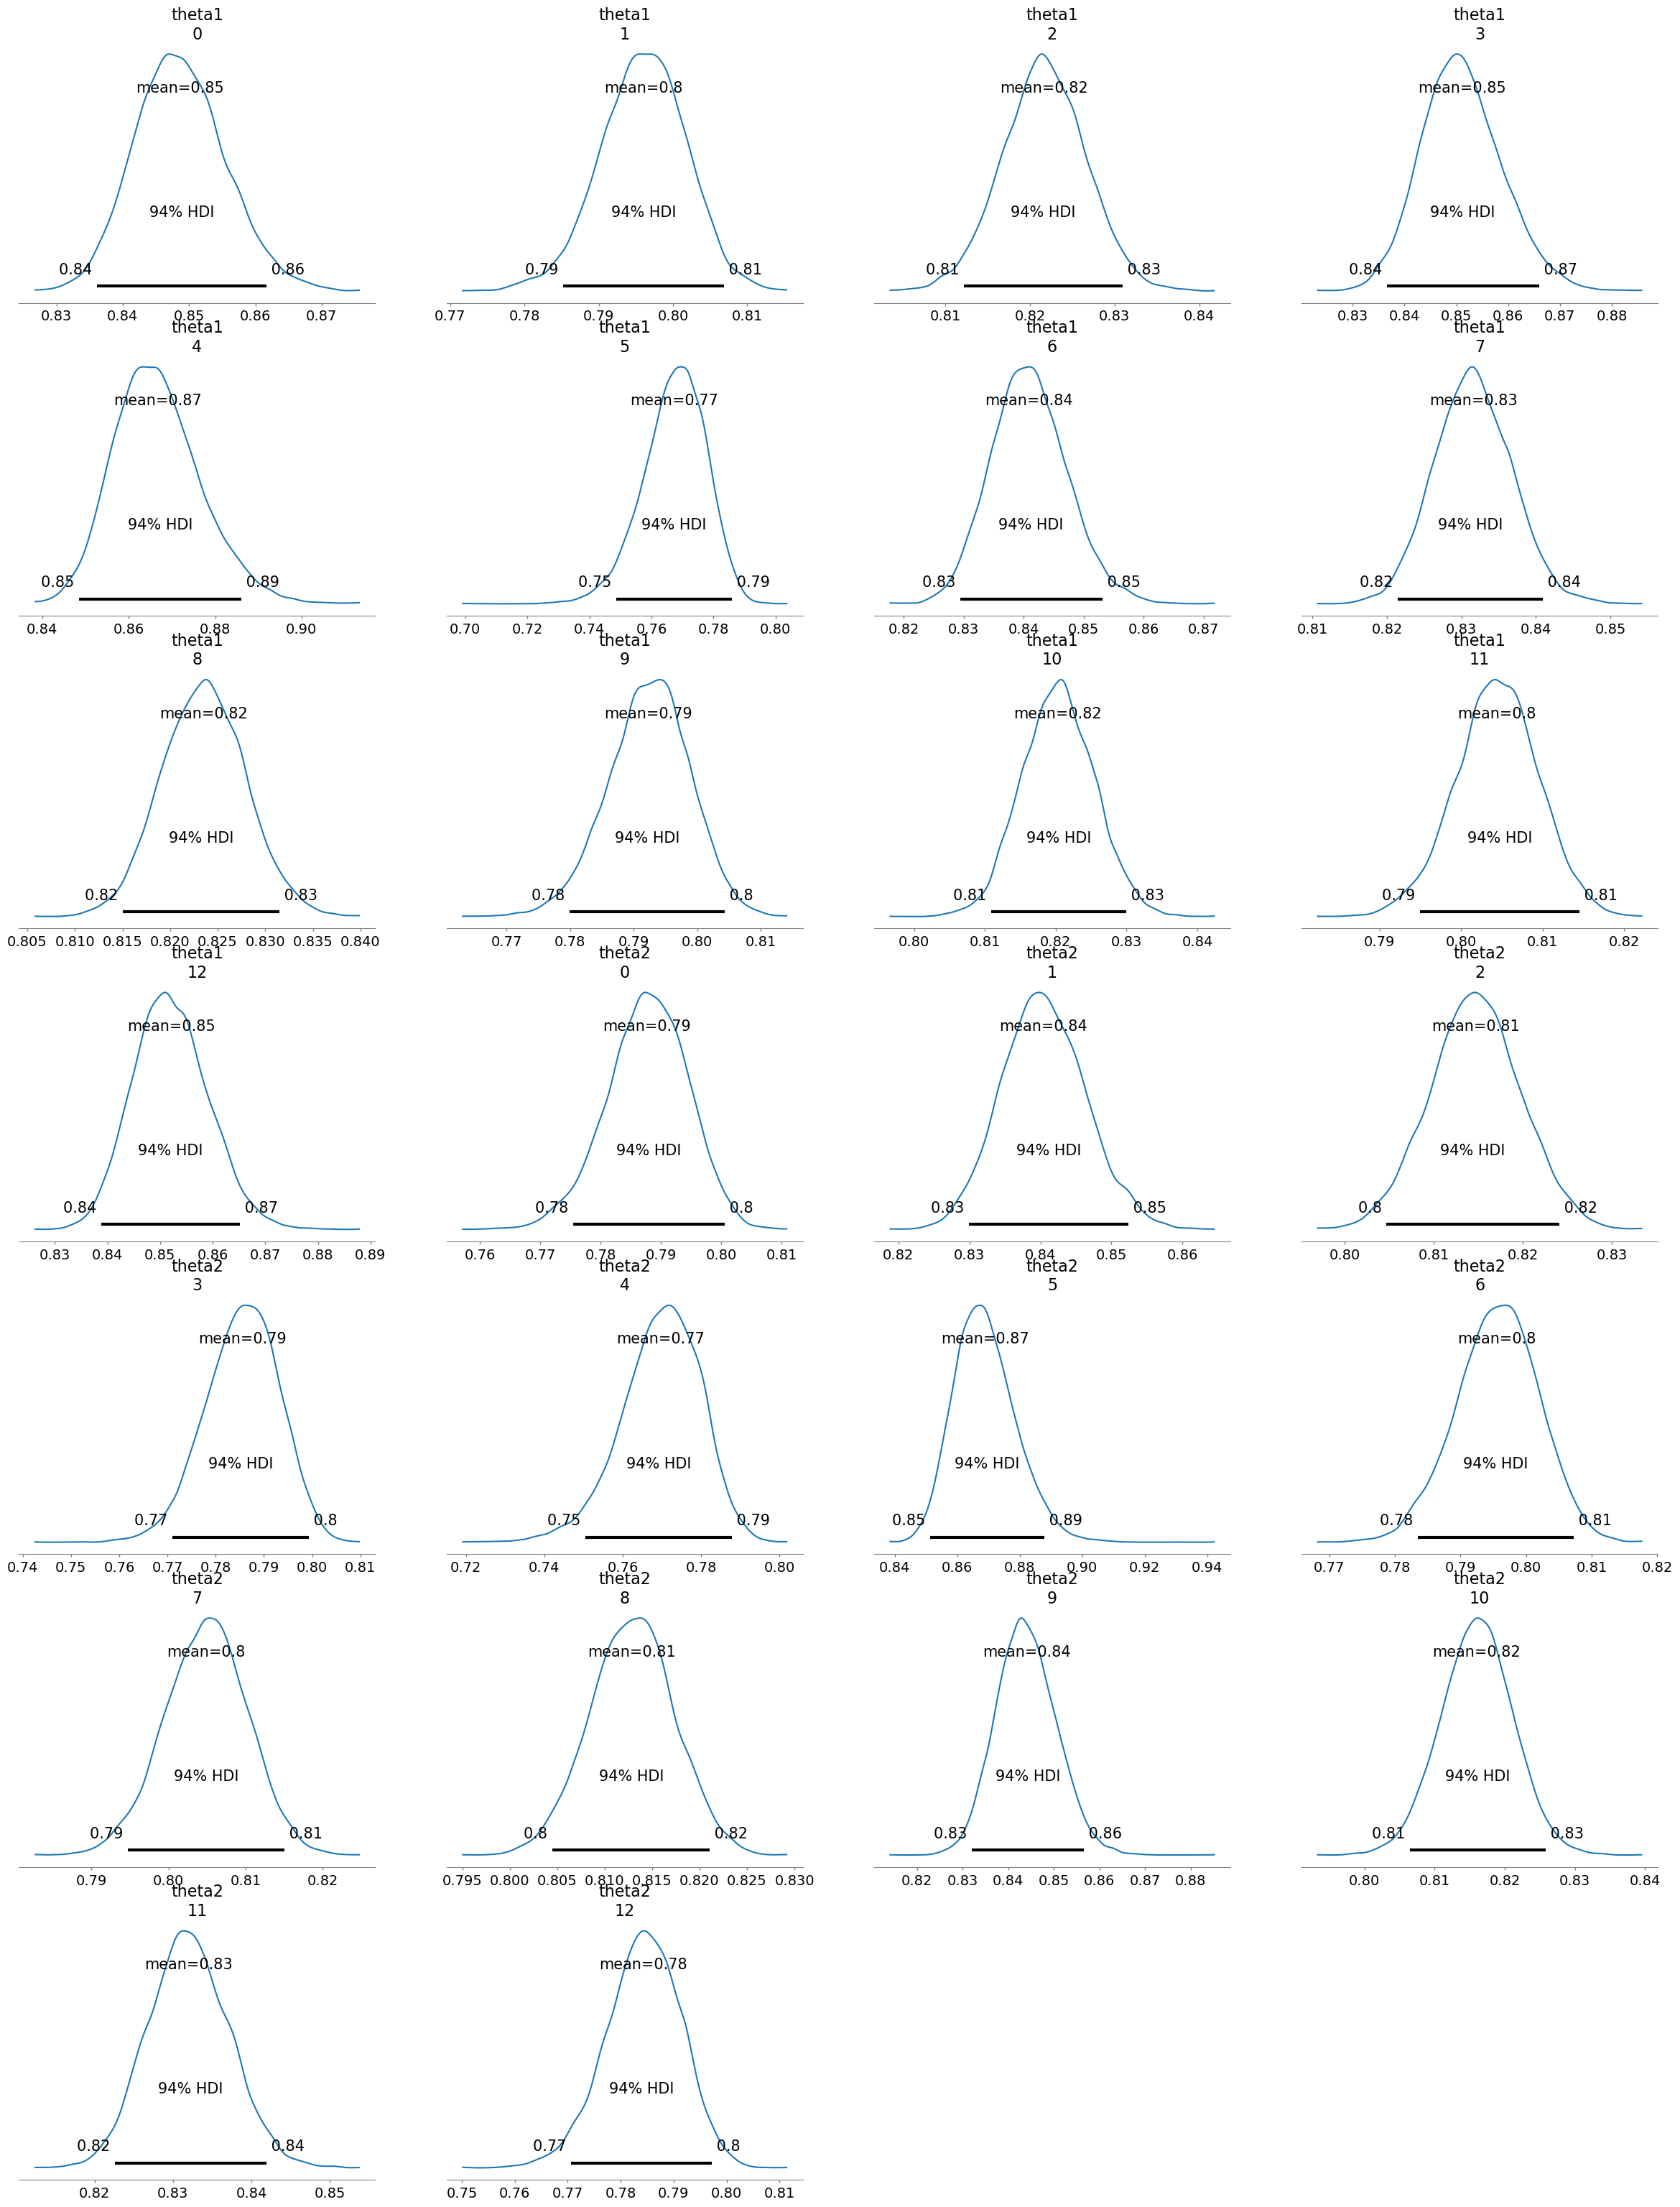

In [40]:
import pymc as pm
import numpy as np
import logging

# Define change points
change_points = []
for i in range(len(df) - 1):
    if df.iloc[i]["eel1_reliability"] != df.iloc[i + 1]["eel1_reliability"]:
        change_points.append(i)
change_points = sorted(change_points)

block_idx = np.digitize(np.arange(len(df)), change_points).astype(int) # trial별로 해당 블럭 인덱스를 알려줌 (예: [0,0,0,1,1,2,...])

N = (df["n1"] + df["n2"]).values

with pm.Model() as model:
    # 사전확률
        # 변화구간 수 + 1 개수만큼 reliability parameter 생성.
        # 각 block마다 고정된 theta를 가지며, 이들은 Beta 분포에서 샘플링됨.
        # theta1, theta2는 각각 두 개의 eel에 대한 reliability.
    theta1 = pm.Beta("theta1", 1, 1, shape=len(change_points) + 1) 
    theta2 = pm.Beta("theta2", 1, 1, shape=len(change_points) + 1) 

    # 우도
        # 각 trial의 성공 확률 p{t}를 trial이 속한 block의 theta{t}로 설정.
        # yt ~ Binomial(Nt, pt)로 잡은 물고기 수 모델링
    
    # p1 = theta1[block_idx]
    # p2 = theta2[block_idx]

    fast_spd = 11.0  # 게임에서 정한 최대 속도
    fish_speed1 = pm.Deterministic("fish_speed1", fast_spd * (1 - theta1[block_idx]))
    fish_speed2 = pm.Deterministic("fish_speed2", fast_spd * (1 - theta2[block_idx]))
    p1 = 1 / (1 + pm.math.exp(-5 * (2 - fish_speed1)))
    p2 = 1 / (1 + pm.math.exp(-5 * (2 - fish_speed2)))

    y1 = pm.Binomial("y1", n=N, p=p1, observed=df["n1"].values)
    y2 = pm.Binomial("y2", n=N, p=p2, observed=df["n2"].values)

    # Bayesian posterior를 샘플링 (총 3만 개, tuning 1천개)
    trace = pm.sample(3000, tune=1000, return_inferencedata=True)  # 일단 단일 프로세스로 시도

    # 기록하기
    logger = logging.getLogger("pymc")
    logger.setLevel(logging.INFO)

# 시각화
import arviz as az
az.plot_posterior(trace, var_names=['theta1', 'theta2'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'theta1'}>,
       <Axes: title={'center': 'theta2'}>], dtype=object)

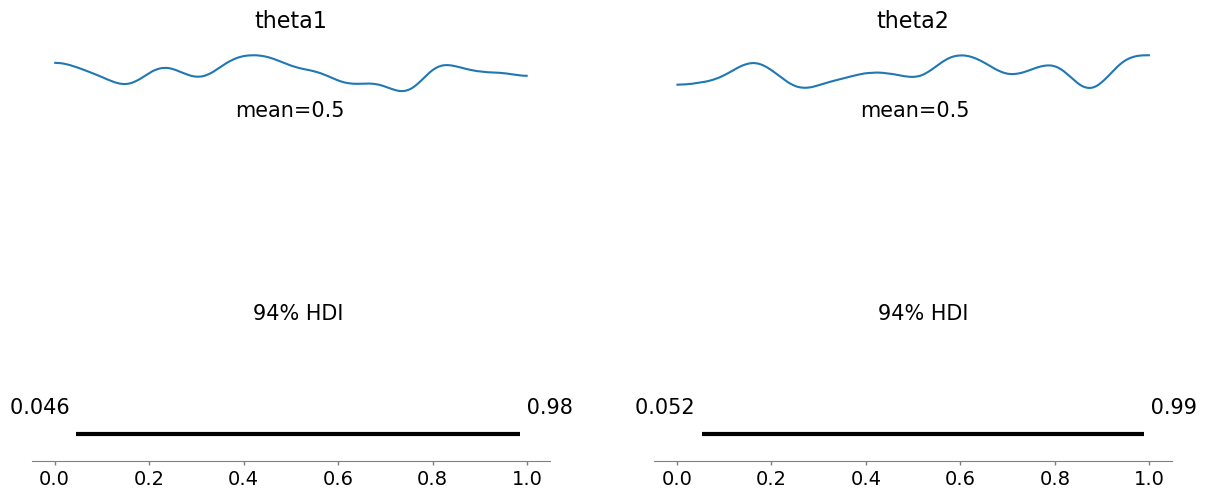

In [59]:
# Sequential Bayesian Updating (직접 prior 갱신)
    # 두 block을 순차적으로 업데이트

import pymc as pm
import numpy as np

# Block 1 data
for idx in range(len(block_idx)-1):
    sub_df = df.iloc[block_idx[idx]:block_idx[idx+1]]
    N1 = (sub_df["n1"] + sub_df["n2"]).values

    with pm.Model() as model1:
        theta1 = pm.Beta("theta1", alpha=1, beta=1)
        theta2 = pm.Beta("theta2", alpha=1, beta=1)
        
        p1 = theta1
        p2 = theta2
        
        y1 = pm.Binomial("y1", n=N1, p=p1, observed=sub_df["n1"].values)
        y2 = pm.Binomial("y2", n=N1, p=p2, observed=sub_df["n2"].values)

        trace = pm.sample(3000, tune=1000)

    # Use posterior of block 1 as prior for block 2
    a1_new = trace.posterior["theta1"].values.flatten().mean() * 20  # Empirical Bayes
    b1_new = (1 - trace.posterior["theta1"].values.flatten().mean()) * 20
    a2_new = trace.posterior["theta2"].values.flatten().mean() * 20
    b2_new = (1 - trace.posterior["theta2"].values.flatten().mean()) * 20

import arviz as az
az.plot_posterior(trace, var_names=['theta1', 'theta2'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'theta1\n0'}>,
        <Axes: title={'center': 'theta1\n1'}>,
        <Axes: title={'center': 'theta1\n2'}>,
        <Axes: title={'center': 'theta1\n3'}>],
       [<Axes: title={'center': 'theta1\n4'}>,
        <Axes: title={'center': 'theta1\n5'}>,
        <Axes: title={'center': 'theta1\n6'}>,
        <Axes: title={'center': 'theta1\n7'}>],
       [<Axes: title={'center': 'theta1\n8'}>,
        <Axes: title={'center': 'theta1\n9'}>,
        <Axes: title={'center': 'theta1\n10'}>,
        <Axes: title={'center': 'theta1\n11'}>],
       [<Axes: title={'center': 'theta1\n12'}>,
        <Axes: title={'center': 'theta2\n0'}>,
        <Axes: title={'center': 'theta2\n1'}>,
        <Axes: title={'center': 'theta2\n2'}>],
       [<Axes: title={'center': 'theta2\n3'}>,
        <Axes: title={'center': 'theta2\n4'}>,
        <Axes: title={'center': 'theta2\n5'}>,
        <Axes: title={'center': 'theta2\n6'}>],
       [<Axes: title={'center': 'theta2\n7'}>,
     

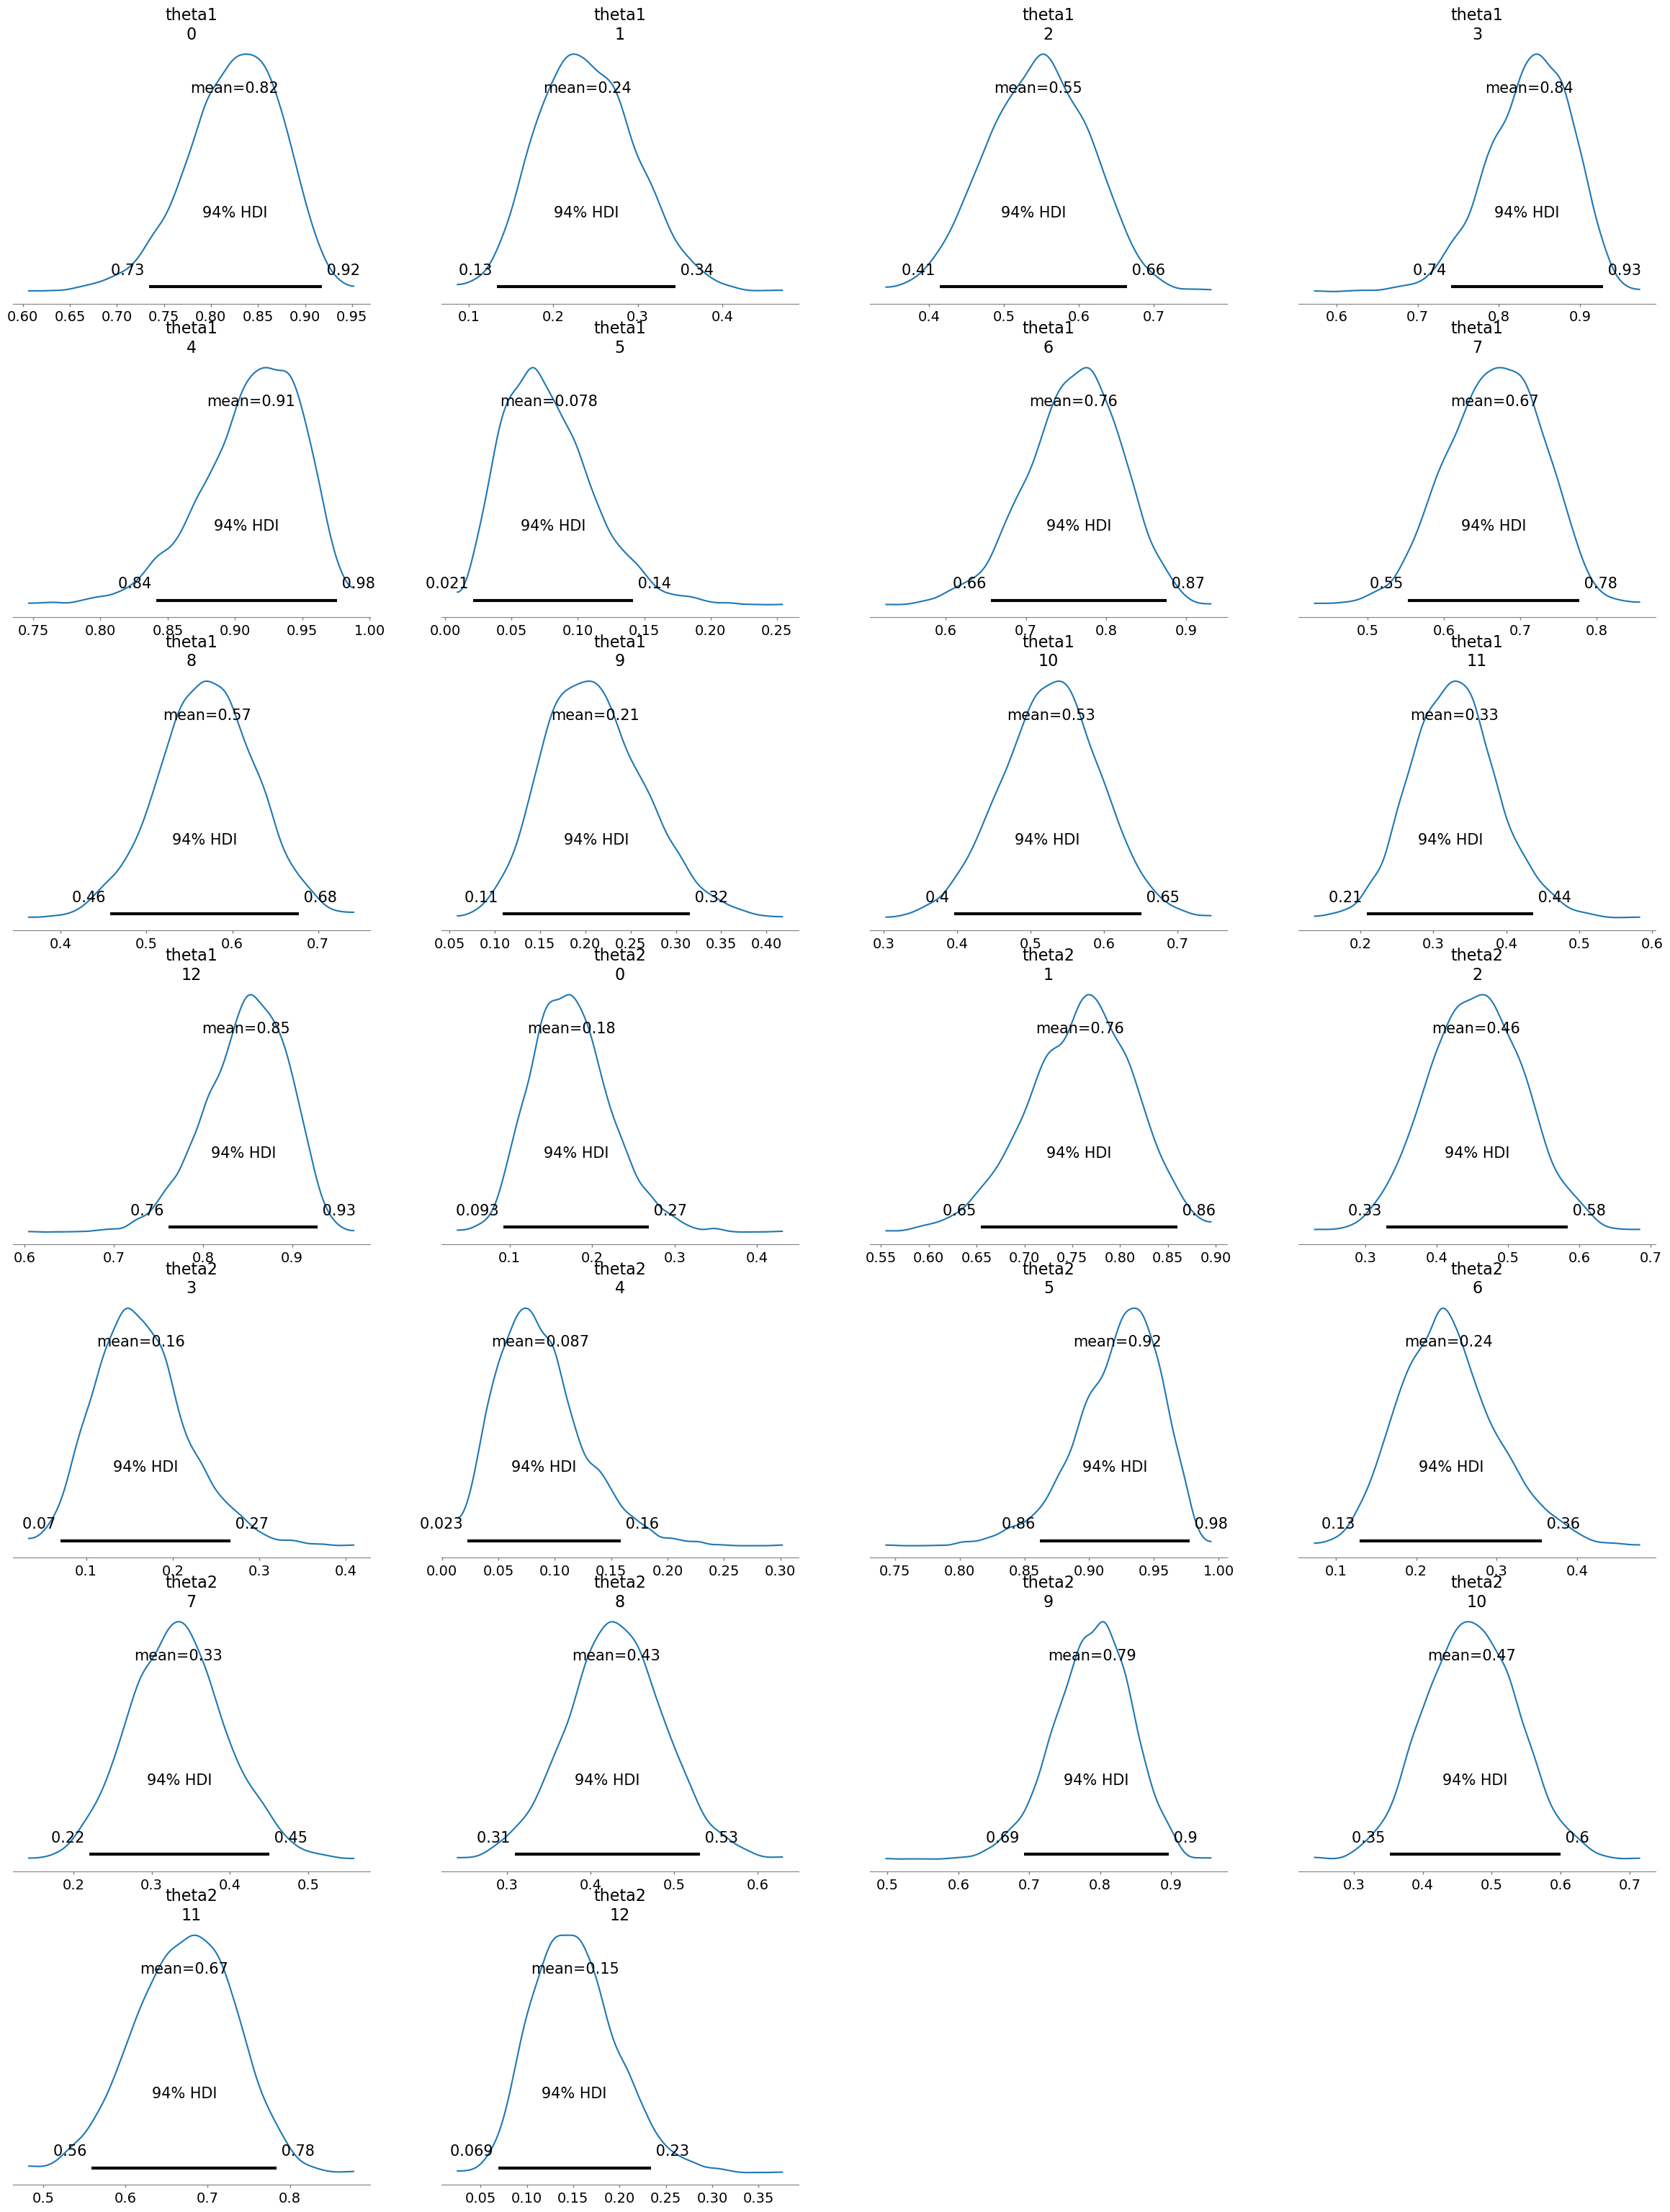

In [58]:
# Sequential Bayesian Updating (직접 prior 갱신)
    # 두 block을 순차적으로 업데이트

import pymc as pm
import numpy as np

# Block 1 data
df1 = df.iloc[block_idx == 0]
N1 = (df1["n1"] + df1["n2"]).values

with pm.Model() as model1:
    theta1_1 = pm.Beta("theta1", alpha=1, beta=1)
    theta2_1 = pm.Beta("theta2", alpha=1, beta=1)
    
    p1 = theta1_1
    p2 = theta2_1
    
    y1 = pm.Binomial("y1", n=N1, p=p1, observed=df1["n1"].values)
    y2 = pm.Binomial("y2", n=N1, p=p2, observed=df1["n2"].values)

    trace1 = pm.sample(3000, tune=1000)

# Use posterior of block 1 as prior for block 2
a1_new = trace1.posterior["theta1"].values.flatten().mean() * 20  # Empirical Bayes
b1_new = (1 - trace1.posterior["theta1"].values.flatten().mean()) * 20
a2_new = trace1.posterior["theta2"].values.flatten().mean() * 20
b2_new = (1 - trace1.posterior["theta2"].values.flatten().mean()) * 20

# Block 2 data
df2 = df.iloc[block_idx == 1]
N2 = (df2["n1"] + df2["n2"]).values

with pm.Model() as model2:
    theta1_2 = pm.Beta("theta1", alpha=a1_new, beta=b1_new)
    theta2_2 = pm.Beta("theta2", alpha=a2_new, beta=b2_new)

    p1 = theta1_2
    p2 = theta2_2

    y1 = pm.Binomial("y1", n=N2, p=p1, observed=df2["n1"].values)
    y2 = pm.Binomial("y2", n=N2, p=p2, observed=df2["n2"].values)

    trace2 = pm.sample(3000, tune=1000)

import arviz as az
az.plot_posterior(trace, var_names=['theta1', 'theta2'])

In [41]:
# informed block-wise change
import numpy as np
import pymc as pm

change_points = []
N = 3

for i in range(len(df) - 1):
    if df.iloc[i]['eel1_reliability'] != df.iloc[i + 1]['eel1_reliability']:
        change_points.append(i)

change_points = sorted(change_points)
block_idx = np.digitize(np.arange(len(df)), change_points).astype(int)

N = df["n1"] + df["n2"]  # 혹은 고정된 값 사용

with pm.Model() as model:
    theta1 = pm.Beta("theta1", 1, 1, shape=len(change_points)+1)
    theta2 = pm.Beta("theta2", 1, 1, shape=len(change_points)+1)

    p1 = theta1[block_idx]
    p2 = theta2[block_idx]

    y1 = pm.Binomial("y1", n=N.values, p=p1, observed=df["n1"].values)
    y2 = pm.Binomial("y2", n=N.values, p=p2, observed=df["n2"].values)

    # y1 = pm.Binomial("y1", n=N, p=p1, observed=df["n1"])
    # y2 = pm.Binomial("y2", n=N, p=p2, observed=df["n2"])

    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


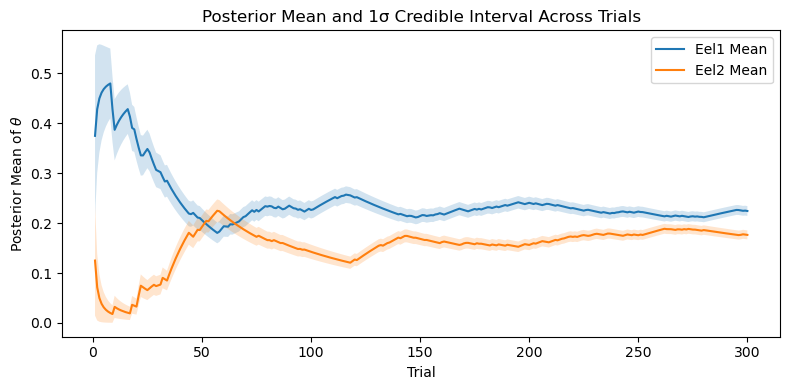

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) 분산 계산 및 추가 ———
# Beta 분포 분산: αβ / [ (α+β)^2 (α+β+1) ]
post_df['var1'] = (
    post_df['alpha1'] * post_df['beta1']
    / ((post_df['alpha1'] + post_df['beta1'])**2 * (post_df['alpha1'] + post_df['beta1'] + 1))
)
post_df['var2'] = (
    post_df['alpha2'] * post_df['beta2']
    / ((post_df['alpha2'] + post_df['beta2'])**2 * (post_df['alpha2'] + post_df['beta2'] + 1))
)

# (선택) 표준편차도 계산해두면 시각화할 때 편리합니다.
post_df['std1'] = np.sqrt(post_df['var1'])
post_df['std2'] = np.sqrt(post_df['var2'])

# ——— 2) 사후평균 선형 플롯 + 불확실성 표시 ———
plt.figure(figsize=(8, 4))
# Eel1
plt.plot(post_df['trial'], post_df['mean1'], label='Eel1 Mean')
plt.fill_between(
    post_df['trial'],
    post_df['mean1'] - post_df['std1'],
    post_df['mean1'] + post_df['std1'],
    alpha=0.2
)
# Eel2
plt.plot(post_df['trial'], post_df['mean2'], label='Eel2 Mean')
plt.fill_between(
    post_df['trial'],
    post_df['mean2'] - post_df['std2'],
    post_df['mean2'] + post_df['std2'],
    alpha=0.2
)

plt.xlabel('Trial')
plt.ylabel(r'Posterior Mean of $\theta$')
plt.title('Posterior Mean and 1σ Credible Interval Across Trials')
plt.legend()
plt.tight_layout()
plt.show()


##### Draft

In [43]:
import pandas as pd
import numpy as np

# df: DataFrame with columns ['trial_idx', 'n1', 'n2', ...]
# Parameters
N = 6                    # 최대 물고기 수 (또는 시도 횟수)
W = 15                   # 슬라이딩 윈도우 크기
n_samps = 10000          # Monte Carlo 샘플 수

# 결과 저장
records = []

for i in range(len(df)):
    # 슬라이딩 윈도우 범위 설정
    start = max(0, i - W + 1)
    window = df.iloc[start:i+1]
    t = len(window)
    
    # 윈도우 내 성공/실패 합계
    s1 = window['n1'].sum()
    f1 = window['n1'].count() * N - s1
    s2 = window['n2'].sum()
    f2 = window['n2'].count() * N - s2

    # Beta posterior 파라미터
    alpha1, beta1 = 1 + s1, 1 + f1
    alpha2, beta2 = 1 + s2, 1 + f2

    # Posterior mean
    mean1 = alpha1 / (alpha1 + beta1)
    mean2 = alpha2 / (alpha2 + beta2)

    # Monte Carlo로 P(theta1 > theta2)
    x = np.random.beta(alpha1, beta1, size=n_samps)
    y = np.random.beta(alpha2, beta2, size=n_samps)
    p12 = np.mean(x > y)

    records.append({
        'trial': df.at[i, 'trial_idx'],
        'alpha1': alpha1, 'beta1': beta1,
        'alpha2': alpha2, 'beta2': beta2,
        'mean1': mean1, 'mean2': mean2,
        'P(theta1>theta2)': p12
    })

# DataFrame으로 변환
post_df = pd.DataFrame(records)
print(post_df.head(30))


    trial  alpha1  beta1  alpha2  beta2     mean1     mean2  P(theta1>theta2)
0       1       3      5       1      7  0.375000  0.125000            0.9014
1       2       6      8       1     13  0.428571  0.071429            0.9922
2       3       9     11       1     19  0.450000  0.050000            0.9993
3       4      12     14       1     25  0.461538  0.038462            1.0000
4       5      15     17       1     31  0.468750  0.031250            1.0000
5       6      18     20       1     37  0.473684  0.026316            1.0000
6       7      21     23       1     43  0.477273  0.022727            1.0000
7       8      24     26       1     49  0.480000  0.020000            1.0000
8       9      24     32       1     55  0.428571  0.017857            1.0000
9      10      24     38       2     60  0.387097  0.032258            1.0000
10     11      27     41       2     66  0.397059  0.029412            1.0000
11     12      30     44       2     72  0.405405  0.027027     

In [44]:
import pandas as pd
import numpy as np
from math import comb

theta_low, theta_high = 0.1, 0.25
post_low, post_high = 0.5, 0.5
records = []
N = 6

for _, row in df.iterrows():
    n1, n2 = int(row['n1']), int(row['n2'])

    # 1) 로그-우도 계산
    ll_low  = (n1*np.log(theta_low)  + (N-n1)*np.log(1-theta_low)
             + n2*np.log(theta_low)  + (N-n2)*np.log(1-theta_low))
    ll_high = (n1*np.log(theta_high) + (N-n1)*np.log(1-theta_high)
             + n2*np.log(theta_high) + (N-n2)*np.log(1-theta_high))

    # 2) 로그-사후 unnormalized
    lpost_low  = np.log(post_low)  + ll_low
    lpost_high = np.log(post_high) + ll_high

    # 3) 안정적 normalization
    m = max(lpost_low, lpost_high)
    post_low  = np.exp(lpost_low  - m)
    post_high = np.exp(lpost_high - m)
    Z = post_low + post_high
    post_low  /= Z
    post_high /= Z

    records.append({
        'post_low':  post_low,
        'post_high': post_high,
        'MAP_state': 'low' if post_low>post_high else 'high'
    })

post_df = pd.DataFrame(records)
print(post_df.head(30))


    post_low  post_high MAP_state
0   0.497659   0.502341      high
1   0.246504   0.753496      high
2   0.097499   0.902501      high
3   0.034446   0.965554      high
4   0.011644   0.988356      high
5   0.003875   0.996125      high
6   0.001283   0.998717      high
7   0.000424   0.999576      high
8   0.003768   0.996232      high
9   0.011117   0.988883      high
10  0.003699   0.996301      high
11  0.001224   0.998776      high
12  0.000405   0.999595      high
13  0.000134   0.999866      high
14  0.000044   0.999956      high
15  0.000015   0.999985      high
16  0.000043   0.999957      high
17  0.000043   0.999957      high
18  0.000043   0.999957      high
19  0.000379   0.999621      high
20  0.000125   0.999875      high
21  0.000041   0.999959      high
22  0.000041   0.999959      high
23  0.000014   0.999986      high
24  0.000004   0.999996      high
25  0.000004   0.999996      high
26  0.000013   0.999987      high
27  0.000039   0.999961      high
28  0.000348  

In [45]:
import pandas as pd
from math import comb

# (A) 사전: P(H=low)=P(H=high)=0.5
post_low, post_high = 0.5, 0.5

# (B) 가능한 θ 값
N = 6

records = []

for _, row in df.iterrows():
    n1, n2 = int(row['n1']), int(row['n2'])
    comp1, comp2 = float(row["eel1_reliability"]), float(row["eel2_reliability"])
    
    # Joint likelihood under each state (independent 가정)
    like_low  = (comb(N, n1) * comp1**n1  * (1-comp1)**(N-n1)) \
              * (comb(N, n2) * comp1**n2  * (1-comp1)**(N-n2))
    like_high = (comb(N, n1) * comp2**n1 * (1-comp2)**(N-n1)) \
              * (comb(N, n2) * comp2**n2 * (1-comp2)**(N-n2))

    # (C) Bayes 업데이트
    unnorm_low  = post_low  * like_low
    unnorm_high = post_high * like_high
    Z = unnorm_low + unnorm_high

    post_low, post_high = unnorm_low/Z, unnorm_high/Z

    records.append({
        'post_low': post_low,
        'post_high': post_high,
        'MAP_state': 'low' if post_low>post_high else 'high'
    })

post_df = pd.DataFrame(records)
print(post_df.head(30))


    post_low     post_high MAP_state
0   0.502341  4.976585e-01       low
1   0.753496  2.465043e-01       low
2   0.902501  9.749948e-02       low
3   0.965554  3.444629e-02       low
4   0.988356  1.164369e-02       low
5   0.996125  3.875271e-03       low
6   0.998717  1.283045e-03       low
7   0.999576  4.240593e-04       low
8   0.996232  3.768305e-03       low
9   0.988883  1.111692e-02       low
10  0.996301  3.698634e-03       low
11  0.998776  1.224418e-03       low
12  0.999595  4.046664e-04       low
13  0.999866  1.336676e-04       low
14  0.999956  4.414446e-05       low
15  0.999985  1.457808e-05       low
16  0.999957  4.332528e-05       low
17  0.999957  4.292142e-05       low
18  0.999957  4.252131e-05       low
19  0.999621  3.789967e-04       low
20  0.999875  1.251863e-04       low
21  0.999959  4.134324e-05       low
22  0.999959  4.095785e-05       low
23  0.999986  1.352571e-05       low
24  0.999959  4.095785e-05       low
25  0.999959  4.134324e-05       low
2

In [46]:
import pandas as pd
from math import comb

# binomial operator
def likelihood(n, reliability):
    return comb(6, n) * reliability**n * (1 - reliability)**(6 - n)


# ——— 1) 사전 설정 ———
# df: 이전에 생성한 DataFrame (cols: 'trial_idx','n1','n2', ...)
# uninformative prior: Beta(1,1)
    # alpha = the cumulative number of catched fish (e.g. n1)
    # beta  = the cumulative number of missed fish (e.g. 6(=total) - n1)
alpha1, beta1 = 1.0, 1.0
alpha2, beta2 = 1.0, 1.0

# 결과 저장을 위한 리스트
posterior_records = []

# ——— 2) 각 trial별로 업데이트 ———
for _, row in df.iterrows():
    n1, n2 = row['n1'], row['n2']
    
    # eel1 업데이트
    alpha1 += n1
    beta1  += 6 - n1
    
    # eel2 업데이트
    alpha2 += n2
    beta2  += 6 - n2
    
    # joint likelihood
        # P(n1, n2 | H) = P(n1 | H) * P(n2 | H)
    likelihood1 = likelihood(n1, row["eel1_reliability"]) * likelihood(n2, 1-row["eel1_reliability"]) # eel1 기준으로 reliability 판단
    likelihood2 = likelihood(n2, row["eel2_reliability"]) * likelihood(n1, 1-row["eel2_reliability"]) # eel2 기준으로 reliability 판단

    # posterior
    posterior1 = alpha1 * beta1 * likelihood1
    posterior2 = alpha2 * beta2 * likelihood2

    # 사후 파라미터와 사후평균 저장
    posterior_records.append({
        'trial': row['trial_idx'],
        'alpha1': alpha1,            # eel1 posterior α
        'beta1':  beta1,             # eel1 posterior β
        'mean1':  alpha1/(alpha1+beta1),
        'alpha2': alpha2,            # eel2 posterior α
        'beta2':  beta2,             # eel2 posterior β
        'mean2':  alpha2/(alpha2+beta2),
    })

# ——— 3) DataFrame으로 변환 및 확인 ———
post_df = pd.DataFrame(posterior_records)
print(post_df.tail(10))  # 첫 10개 trial의 사후 분포 파라미터 및 평균 출력


     trial  alpha1   beta1     mean1  alpha2   beta2     mean2
289    291   388.0  1354.0  0.222732   312.0  1430.0  0.179104
290    292   391.0  1357.0  0.223684   312.0  1436.0  0.178490
291    293   394.0  1360.0  0.224629   312.0  1442.0  0.177879
292    294   397.0  1363.0  0.225568   312.0  1448.0  0.177273
293    295   400.0  1366.0  0.226501   312.0  1454.0  0.176670
294    296   401.0  1371.0  0.226298   312.0  1460.0  0.176072
295    297   401.0  1377.0  0.225534   314.0  1464.0  0.176603
296    298   401.0  1383.0  0.224776   317.0  1467.0  0.177691
297    299   403.0  1387.0  0.225140   317.0  1473.0  0.177095
298    300   403.0  1393.0  0.224388   317.0  1479.0  0.176503


#### 그래프

In [47]:
# 비교분석 = 추정치 차이(mean1−mean2) vs. 실제 잡힌 물고기 차이(n1−n2)
# 검증 = 상관분석 또는 창(window)별 평균 비교를 통해 “학습→선택→성과”의 일관성을 평가

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# ——— 0) 전제: df와 post_df가 이미 메모리에 로드되어 있다고 가정 ———
# df: ['trial_idx','n1','n2', ...]
# post_df: ['trial','mean1','mean2', ...]

# ——— 1) df와 post_df 병합 ———
merged = pd.merge(
    df[['trial_idx', 'n1', 'n2']],
    post_df[['trial', 'mean1', 'mean2']],
    left_on='trial_idx',
    right_on='trial'
)

# ——— 2) Δmean, Δcatch 계산 ———
merged['delta_mean']  = merged['mean1']  - merged['mean2']
merged['delta_catch'] = merged['n1']     - merged['n2']

##### Pearson 상관계수 계산

* ρ(rho): 상관관계의 크기
* p-value: 유의미성

In [48]:
# ——— 3) Pearson 상관계수 계산 ———
# Pearson 상관계수를 통해 Δmean과 Δcatch의 관계 강도를 정량화
rho, pval = pearsonr(merged['delta_mean'], merged['delta_catch'])
print(f"Pearson correlation: ρ = {rho:.3f}, p = {pval:.3f}")

# ——— 4) Posterior mean 추이 시계열 ———
# plt.figure(figsize=(8, 3))
# plt.plot(merged['trial_idx'], merged['mean1'], label='Eel1 Mean')
# plt.plot(merged['trial_idx'], merged['mean2'], label='Eel2 Mean')
# plt.xlabel('Trial')
# plt.ylabel('Posterior Mean')
# plt.title('Eel reliability Estimates Over Trials')
# plt.legend()
# plt.tight_layout()
# plt.show()



Pearson correlation: ρ = 0.160, p = 0.005


##### Posterior mean 추이 시계열

> 사후평균 추이 시계열로 각 eel reliability 추정 변화를 확인

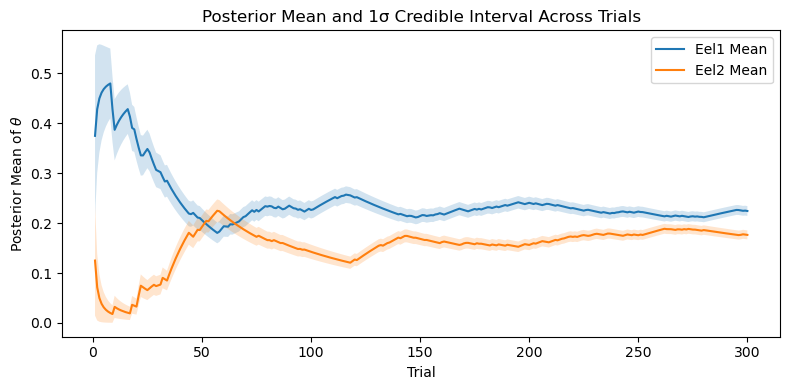

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) 분산 계산 및 추가 ———
# Beta 분포 분산: αβ / [ (α+β)^2 (α+β+1) ]
post_df['var1'] = (
    post_df['alpha1'] * post_df['beta1']
    / ((post_df['alpha1'] + post_df['beta1'])**2 * (post_df['alpha1'] + post_df['beta1'] + 1))
)
post_df['var2'] = (
    post_df['alpha2'] * post_df['beta2']
    / ((post_df['alpha2'] + post_df['beta2'])**2 * (post_df['alpha2'] + post_df['beta2'] + 1))
)

# (선택) 표준편차도 계산해두면 시각화할 때 편리합니다.
post_df['std1'] = np.sqrt(post_df['var1'])
post_df['std2'] = np.sqrt(post_df['var2'])

# ——— 2) 사후평균 선형 플롯 + 불확실성 표시 ———
plt.figure(figsize=(8, 4))
# Eel1
plt.plot(post_df['trial'], post_df['mean1'], label='Eel1 Mean')
plt.fill_between(
    post_df['trial'],
    post_df['mean1'] - post_df['std1'],
    post_df['mean1'] + post_df['std1'],
    alpha=0.2
)
# Eel2
plt.plot(post_df['trial'], post_df['mean2'], label='Eel2 Mean')
plt.fill_between(
    post_df['trial'],
    post_df['mean2'] - post_df['std2'],
    post_df['mean2'] + post_df['std2'],
    alpha=0.2
)

plt.xlabel('Trial')
plt.ylabel(r'Posterior Mean of $\theta$')
plt.title('Posterior Mean and 1σ Credible Interval Across Trials')
plt.legend()
plt.tight_layout()
plt.show()


##### Δmean vs Δcatch 산점도 + 회귀선
> 산점도와 회귀선으로 “추정치 차이가 클수록 행동 차이도 커지는지” 시각화
* delta mean > 0 = higher delta, more preferring **eel1** because the learner thinks **eel1's reliability is higher**
* delta mean < 0 = lower delta, more preferring **eel2** because the learner thinks **eel2's reliability is higher**


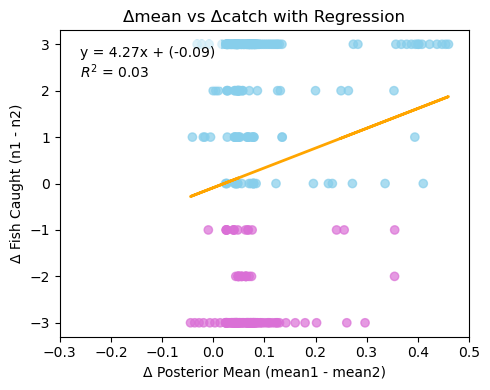

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ——— 데이터 및 모델 준비 (merged DataFrame 필요) ———
X = merged['delta_mean'].values.reshape(-1, 1)
y = merged['delta_catch'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# 회귀식 및 결정계수 계산
coef = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

# 포인트 색상: Δcatch < 0 → 보라색, Δcatch ≥ 0 → 파란색
colors = np.where(merged['delta_catch'] < 0, 'orchid', 'skyblue')

# ——— 플롯 ———
plt.figure(figsize=(5, 4))
plt.scatter(merged['delta_mean'], merged['delta_catch'], c=colors, alpha=0.7)
plt.plot(merged['delta_mean'], y_pred, color='orange', linewidth=2)

plt.xlabel('Δ Posterior Mean (mean1 - mean2)')
plt.ylabel('Δ Fish Caught (n1 - n2)')
plt.title('Δmean vs Δcatch with Regression')
plt.xlim(-0.3, 0.5)

# 회귀식 및 R² 텍스트 표시
eq_text = f'y = {coef:.2f}x + ({intercept:.2f})\n$R^2$ = {r2:.2f}'
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.tight_layout()
plt.show()


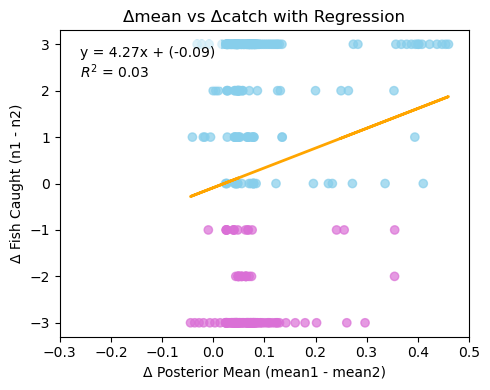

In [51]:
posterior_records

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ——— 데이터 및 모델 준비 (merged DataFrame 필요) ———
X = merged['delta_mean'].values.reshape(-1, 1)
y = merged['delta_catch'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# 회귀식 및 결정계수 계산
coef = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

# 포인트 색상: Δcatch < 0 → 보라색, Δcatch ≥ 0 → 파란색
colors = np.where(merged['delta_catch'] < 0, 'orchid', 'skyblue')

# ——— 플롯 ———
plt.figure(figsize=(5, 4))
plt.scatter(merged['delta_mean'], merged['delta_catch'], c=colors, alpha=0.7)
plt.plot(merged['delta_mean'], y_pred, color='orange', linewidth=2)

plt.xlabel('Δ Posterior Mean (mean1 - mean2)')
plt.ylabel('Δ Fish Caught (n1 - n2)')
plt.title('Δmean vs Δcatch with Regression')
plt.xlim(-0.3, 0.5)

# 회귀식 및 R² 텍스트 표시
eq_text = f'y = {coef:.2f}x + ({intercept:.2f})\n$R^2$ = {r2:.2f}'
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.tight_layout()
plt.show()


##### 주기별 (윈도우 크기=4) 평균 계산 및 시각화
> 윈도우별 평균(4 trial 간격)으로 주기적 학습 추세 비교

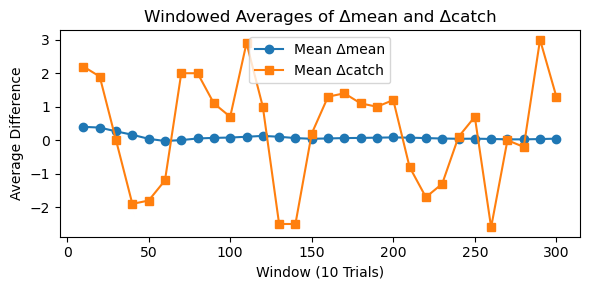

In [52]:
# ——— 6) 주기별 (윈도우 크기=4) 평균 계산 및 시각화 ———
window_step = 10
merged['window'] = ((merged['trial_idx'] - 1) // window_step) + 1
windowed = merged.groupby('window').agg({
    'delta_mean': 'mean',
    'delta_catch': 'mean'
}).reset_index()

plt.figure(figsize=(6, 3))
plt.plot(windowed['window']*window_step, windowed['delta_mean'], marker='o', label='Mean Δmean')
plt.plot(windowed['window']*window_step, windowed['delta_catch'], marker='s', label='Mean Δcatch')
plt.xlabel(f"Window ({window_step} Trials)")
plt.ylabel('Average Difference')
plt.title('Windowed Averages of Δmean and Δcatch')
plt.legend()
plt.tight_layout()
plt.show()
